<font size="8">Analysis of the Podcast Reviews Dataset</font>

# Introduction

This project relies on data loaded from Kaggle dataset (https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28) and processed using Pandas. To get a better feel of data and find useful patterns, the queries and filtering data using SQLite, Pandas, visualizing data with Matplotlib & Seaborn will be performed.

## Objectives of the EDA

The main purpose of the analysis is to provide useful information to podcast publishers and sponsors, based on the insights that will be gained by applying various data analysis technique for the above mentioned data set.

During the analysis main focus will be for:
1. Podcasts content popularity and rating;
2. User behavior and engagement patterns.

## Exploratory Data Analysis Methodology Overview

The steps and procedures that will be included in the analysis of this document are:

* **Data Loading and Preprocessing:** The first phase involves loading the data from the SQLite database using Pandas. Any required data preprocessing steps, such as handling missing values and data type conversions, will be performed during this stage.
  
* **Exploratory Data Analysis (EDA):** A comprehensive EDA will be conducted to gain insights into the dataset. This includes generating statistical summaries, creating visualizations, identifying outliers, and exploring relationships between variables. Correlations, patterns, and trends within the data will be examined to inform subsequent analysis steps.
  
* **Statistical Inference:** Statistical inference will be employed to make meaningful conclusions about the population based on the sample data. This will involve formulating hypotheses, constructing confidence intervals, and conducting hypothesis tests using z tests, t tests as appropriate.
    
* **Interpretation and Conclusion:** The analysis findings will be interpreted in the context of the research objectives. Limitations of the analysis will be acknowledged, and conclusions will be drawn based on the results obtained.

* **Google Data Studio Dashboard:** A Google Data Studio dashboard will be designed to present the analysis results visually. The dashboard will include at least three types of charts that effectively convey key findings and insights from the analysis.

# Exploratory Data Analysis

Based on the information provided by the author, the database contains 4 tables : __categories__, __podcasts__, __reviews__ and __runs__.

The information provided in the __catagories__ and __podcasts__ tables are directly related to the podcasts itself, the __review__ table provides information related to the podcast listener and the evaluation of the podcast, the __runs__ table provides information about the process of collecting (updating-adding) the data set itself, it could be useful for tracking the size of the dataset or determining which rows were added or modified in a particular run.

## Podcasts content popularity and rating

### Data Loading and Preprocessing

This section will include the analysis of podcasts in the dataset and their known properties, as well as the ratings given to them by users.

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from utils import *

In [2]:
db_connection = sqlite3.connect('./database.sqlite') 

For further analysis a new feature of generalized podcast categories will be used. This step facilitates easier comparisons and enhances interpretability of the data.

In [3]:
df_podcasts = pd.read_sql(
    'SELECT r.podcast_id, c.category, '
    'CASE '
        'WHEN c.category = "true-crime" THEN "true crime" '  
        'WHEN c.category IN ("buddhism", "islam", "christianity", "judaism", "hinduism") THEN "religion" '
        'WHEN c.category LIKE "%-%" THEN SUBSTR(category, 1, INSTR(category, "-")-1) '
        'ELSE c.category '
    'END AS general_category '
    'FROM categories c '
    'LEFT JOIN reviews r on c.podcast_id = r.podcast_id',
    db_connection
)

In [4]:
df_podcasts.head()

,podcast_id,category,general_category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts,arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts,arts
3,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts,arts
4,c61aa81c9b929a66f0c1db6cbe5d8548,music,music


### General information about the podcats

In [5]:
num_unique_podcasts = df_podcasts['podcast_id'].nunique()
num_unique_categories = df_podcasts['general_category'].nunique()
num_unique_reviews = df_podcasts.shape[0]

print(f'This dataset consists of records for {num_unique_podcasts} unique podcasts, '
      f'which are assigned to {num_unique_categories} general categories.'
      f' There are {num_unique_reviews} reviews in total for these podcasts.')

This dataset consists of records for 110024 unique podcasts, which are assigned to 20 general categories. There are 4529483 reviews in total for these podcasts.


In [6]:
df_podcasts_grouped = df_podcasts.groupby('general_category').agg(
    number_of_sub_categories=('category', 'nunique'),
    number_of_podcasts=('podcast_id', 'nunique')
).reset_index()

The following general statistics provides information related to the records of the podcast categories in the dataset.

In [7]:
df_podcasts_grouped.describe()

,number_of_sub_categories,number_of_podcasts
count,20.000000,20.000000
mean,5.500000,7152.350000
std,3.748684,5174.837066
min,1.000000,940.000000
25%,3.250000,2276.000000
50%,5.500000,6808.500000
75%,7.000000,10408.500000
max,16.000000,19441.000000


Detailed information regarding the number of sub-categories and number of podcasts for each general category is shown in the following visualiations.

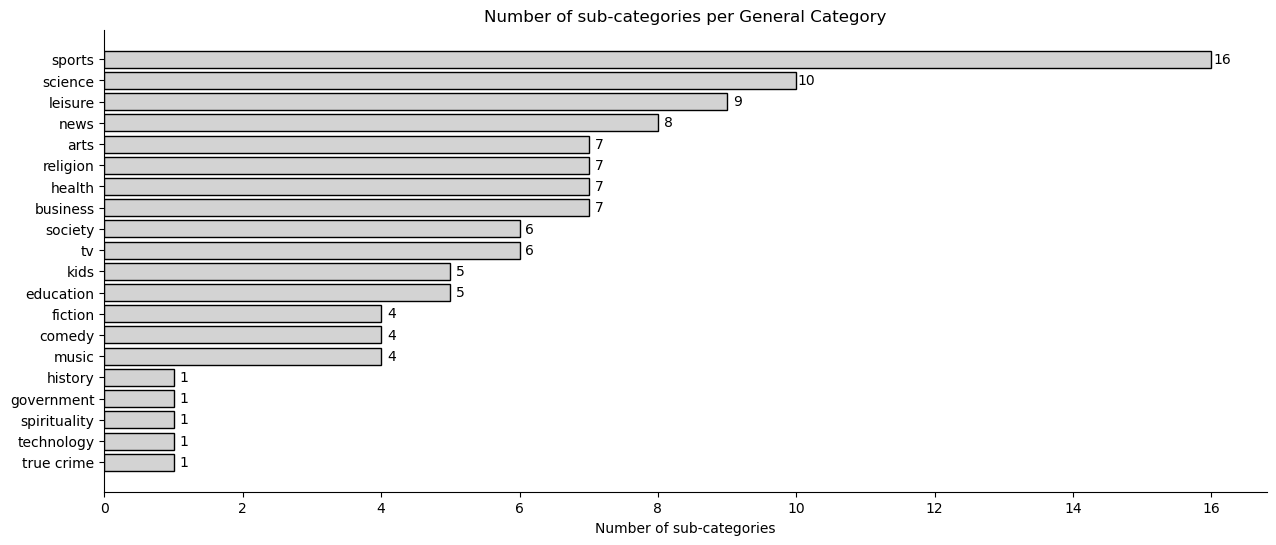

In [8]:
horizontal_bar_plot(
    data_frame=df_podcasts_grouped,
    x_col='general_category',
    y_col='number_of_sub_categories',
    title='Number of sub-categories per General Category',
    values='Number of sub-categories',
    label_x_offset=0.15
)

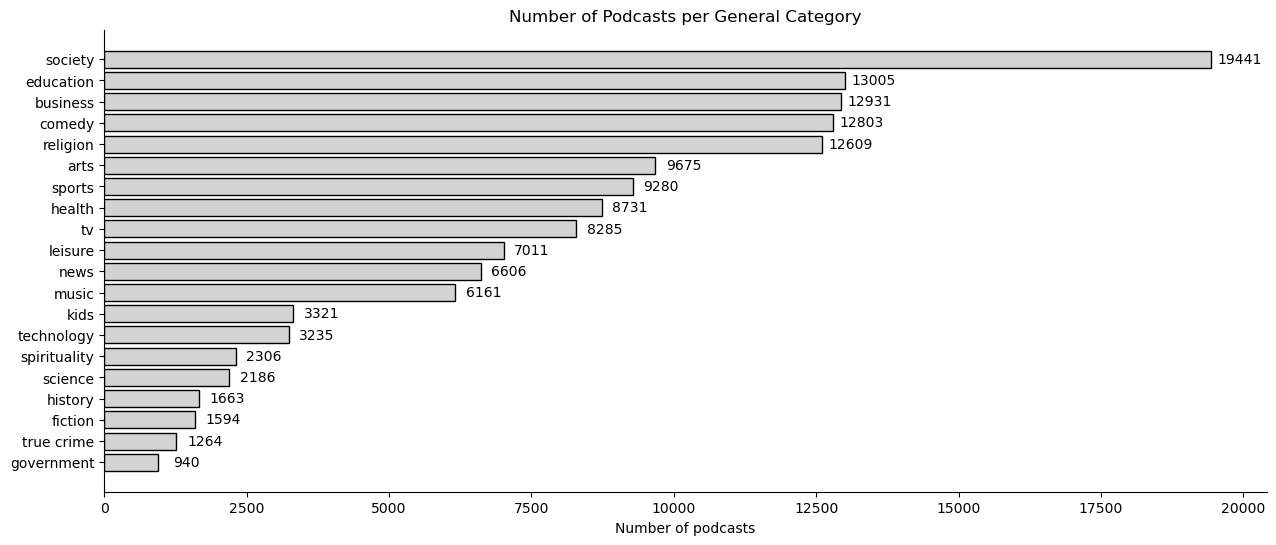

In [9]:
horizontal_bar_plot(
    data_frame=df_podcasts_grouped,
    x_col='general_category',
    y_col='number_of_podcasts',
    title='Number of Podcasts per General Category',
    values='Number of podcasts'
)

In the further analysis of popularity and rating, recorded review data will be additionally used for each generalized general category and as a result of which a new dataframe wil be loaded.

To objectively evaluate and compare the number of reviews and ratings for each category, when preparing data for analysis attention will be drawn to the following criteria in the following order:
* **Popularity and review ratings will be analyzed for generalized categories only.** The popularity of the podcast category will be evaluated using the number of reviews for this category.
* **When calculating the number of reviews, only the unique review "author_id" values will be counted for each podcast separately.** Accordingly, if there is more than one review from the same author for the same podcast id, the podcast review rating will be assumed as an average of the same author rating values. 
* **Only podcasts that have more than 10 reviews will be used for general category rating calculations and comparisons.** In this way, the minimum reliability of the podcast evaluation results will be ensured.

_**Note**: These criteria are accepted with the assumption that each new episode in the podcast has its own new unique number (podcast_id)._

In [10]:
df_reviews = pd.read_sql(
    'SELECT r.podcast_id, r.author_id, '
    'CASE '
        'WHEN c.category = "true-crime" THEN "true crime" '  
        'WHEN c.category IN ("buddhism", "islam", "christianity", "judaism", "hinduism") THEN "religion" '
        'WHEN c.category LIKE "%-%" THEN SUBSTR(category, 1, INSTR(category, "-")-1) '
        'ELSE c.category '
    'END AS general_category, r.rating '
    'FROM categories c '
    'LEFT JOIN reviews r on c.podcast_id = r.podcast_id',
    db_connection
)

First of all, data processing is performed by grouping the reviews of the same review author for the same podcast id and recalculating the rating value.

In [11]:
df_reviews_grouped = df_reviews.groupby(['podcast_id', 'author_id']).agg(
    rating=('rating', 'mean'),
    general_category=('general_category', 'first')
).reset_index()

In the next step, podcasts are grouped by podcast id and podcasts with more than 10 unique reviews are selected for further analysis.

In [12]:
df_reviews_grouped_by_podcast_id = df_reviews_grouped.groupby('podcast_id').agg(
    rating=('rating', 'mean'),
    number_of_reviews=('rating', 'count'),
    category=('general_category', 'first')
).reset_index()

df_reviews_filtered = df_reviews_grouped_by_podcast_id[df_reviews_grouped_by_podcast_id['number_of_reviews'] > 10]

In [13]:
df_reviews_filtered.head()

,podcast_id,rating,number_of_reviews,category
5,a000aa69852b276565c4f5eb9cdd999b,5.000000,15,arts
9,a00155a1dc1d1b9ef4d2d573982207c6,4.312500,48,arts
10,a0015a878cd03b4d6abb92ea3ce55281,5.000000,26,business
21,a0039309599d854d1bf60c00f244bd5f,4.590909,22,arts
27,a005c5ca5880ec5356e04ad5da20b5da,5.000000,26,true crime


In [14]:
df_categories_overview = df_reviews_filtered.groupby('category').agg(
    mean_rating=('rating', 'mean'),
    number_of_podcasts=('podcast_id', 'count'),
    number_of_reviews=('number_of_reviews', 'sum')
).sort_values(by='mean_rating', ascending=False).reset_index()

In [15]:
df_categories_overview

,category,mean_rating,number_of_podcasts,number_of_reviews
0,business,4.899177,3099,185965
1,spirituality,4.860415,39,1689
2,education,4.848762,1922,120577
3,religion,4.833693,1485,86850
4,health,4.826575,1544,105844
5,arts,4.775116,2096,118576
6,music,4.772550,656,31529
7,comedy,4.770928,2539,280191
8,leisure,4.745917,1059,62160
9,kids,4.734283,516,41047


In [16]:
df_categories_overview.describe()

,mean_rating,number_of_podcasts,number_of_reviews
count,20.000000,20.00000,20.000000
mean,4.689772,1097.45000,85336.600000
std,0.154271,887.86589,71140.445251
min,4.286532,39.00000,1689.000000
25%,4.634539,279.50000,29374.500000
50%,4.716603,1042.50000,68572.000000
75%,4.787981,1633.50000,120702.750000
max,4.899177,3099.00000,280191.000000


For better visualization of the results, the number of reviews for each general category is shown in the graph bellow.

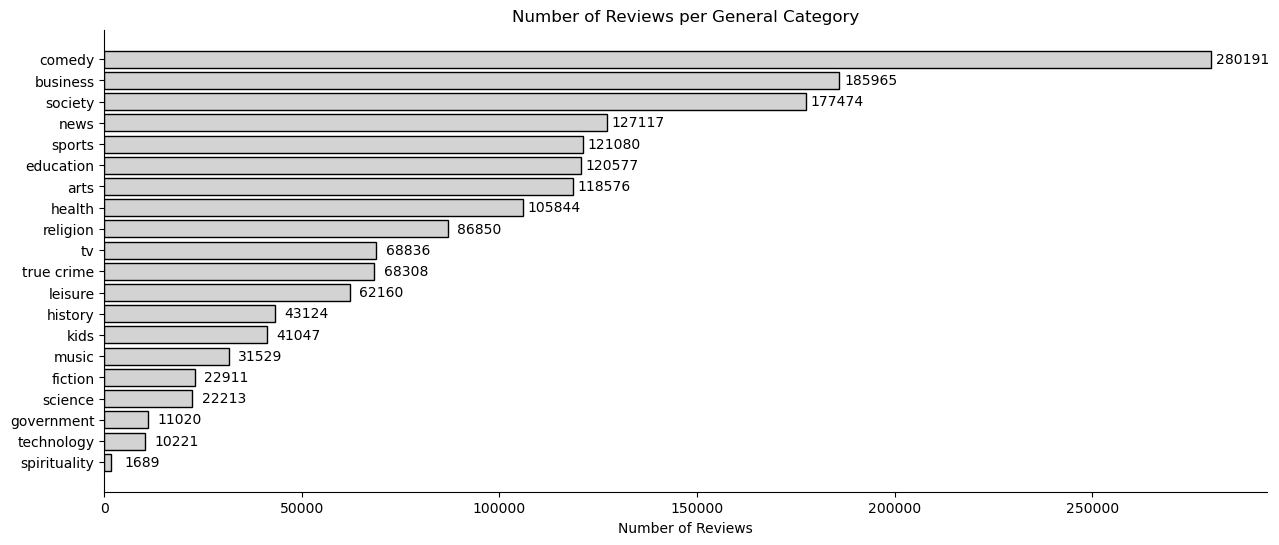

In [17]:
horizontal_bar_plot(
    data_frame=df_categories_overview,
    x_col='category',
    y_col='number_of_reviews',
    title='Number of Reviews per General Category',
    values='Number of Reviews',
    label_x_offset=8000
)

The following graph presents the calculated rating score of the podcast general categories in ascending order, as well as visually presenting the number of podcasts used for the calculations that meet the previously mentioned conditions.

In [18]:
category_values = df_categories_overview['category'].unique().tolist()

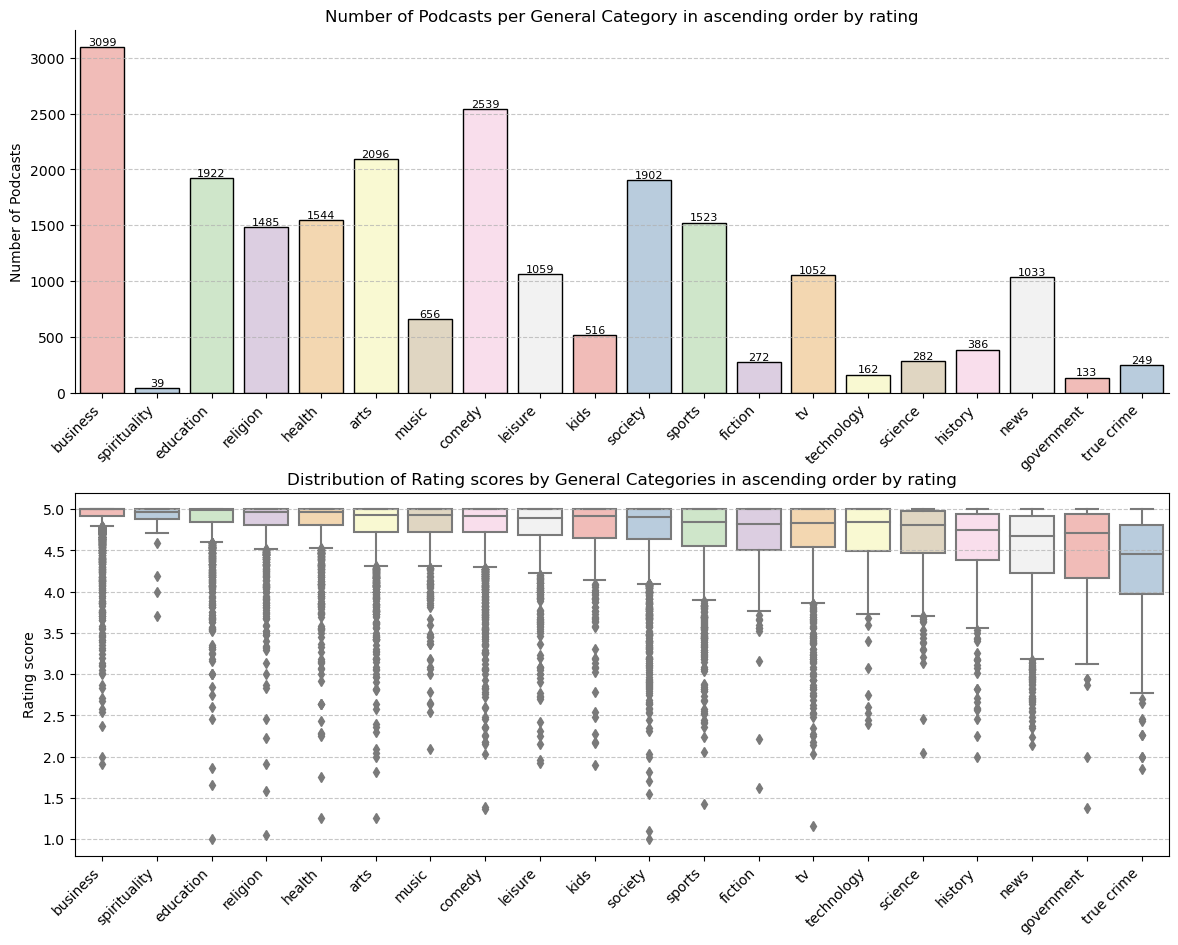

In [19]:
combined_box_bar_plot(
    data_frame1=df_categories_overview,
    data_frame2=df_reviews_filtered,
    x_col1='category',
    y_col1='number_of_podcasts',
    x_col2='category',
    y_col2='rating',
    order=category_values,
    title1='Number of Podcasts per General Category in ascending order by rating',
    title2='Distribution of Rating scores by General Categories in ascending order by rating',
    y_label1='Number of Podcasts',
    y_label2='Rating score'
)

More precise information about each category, in ascending order by mean rating value, is provided in the general statistics table below.

In [20]:
pivoted_df_reviews = df_reviews_filtered.pivot(index='podcast_id', columns='category', values='rating')

pivoted_df_reviews = pivoted_df_reviews[category_values]

pivoted_df_reviews.describe()

category,business,spirituality,education,religion,health,arts,music,comedy,leisure,kids,society,sports,fiction,tv,technology,science,history,news,government,true crime
count,3099.000000,39.000000,1922.000000,1485.000000,1544.000000,2096.000000,656.000000,2539.000000,1059.000000,516.000000,1902.000000,1523.000000,272.000000,1052.000000,162.000000,282.000000,386.000000,1033.000000,133.000000,249.000000
mean,4.899177,4.860415,4.848762,4.833693,4.826575,4.775116,4.772550,4.770928,4.745917,4.734283,4.698923,4.674222,4.663799,4.642569,4.636857,4.627584,4.567943,4.471654,4.457944,4.286532
std,0.260953,0.284044,0.318965,0.330240,0.352063,0.380541,0.385458,0.392041,0.409860,0.455922,0.498064,0.467541,0.436206,0.524452,0.534745,0.472010,0.532007,0.572549,0.638885,0.664466
min,1.909091,3.705882,1.000000,1.050000,1.250000,1.250000,2.090909,1.368421,1.916667,1.898256,1.000000,1.423077,1.615385,1.153846,2.400000,2.047619,2.000000,2.142857,1.380952,1.846154
25%,4.915493,4.876488,4.838710,4.805556,4.809271,4.721899,4.716615,4.716148,4.683014,4.650895,4.636389,4.555556,4.498113,4.540865,4.491828,4.466667,4.385100,4.221212,4.166667,3.970588
50%,5.000000,4.962963,4.983192,4.961538,4.963189,4.921875,4.924528,4.921569,4.897260,4.921311,4.909091,4.848485,4.812937,4.833333,4.843750,4.812500,4.750000,4.670541,4.707071,4.450000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.976461,4.941176,4.916667,4.937500,4.805369
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


The information seen in general statistics regarding rating values and number of podcasts, which we will use in further analyses, are saved in a new dataframe. Data is sorted in ascending order by rating mean value.

In [21]:
df_reviews_statistics = df_reviews_filtered.groupby('category')['rating'].agg(
    [
        'mean',
        'std',
        'count'
    ]
).sort_values(by='mean', ascending=False).reset_index()

df_reviews_statistics.head(10)

,category,mean,std,count
0,business,4.899177,0.260953,3099
1,spirituality,4.860415,0.284044,39
2,education,4.848762,0.318965,1922
3,religion,4.833693,0.330240,1485
4,health,4.826575,0.352063,1544
5,arts,4.775116,0.380541,2096
6,music,4.772550,0.385458,656
7,comedy,4.770928,0.392041,2539
8,leisure,4.745917,0.409860,1059
9,kids,4.734283,0.455922,516


### Podcast rating value differences based on number of reviews

In this section it will be assessed whether there is a relationship between podcast rating value and the number of reviews for such podcast.
To compute pairwise correlation of features, a __Pearson__ (standard correlation coefficient, which is measured of linear correlation between two sets of data) method will be used.

In [22]:
corr_rating_by_num_of_reviews = df_reviews_filtered.corr()
corr_rating_by_num_of_reviews

,rating,number_of_reviews
rating,1.000000,-0.085163
number_of_reviews,-0.085163,1.000000


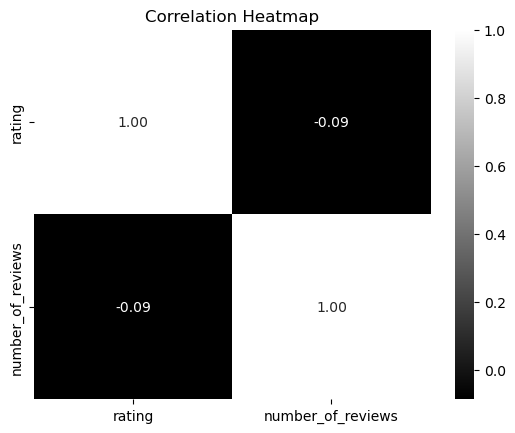

In [23]:
plot_correlation_heatmap(
    correlation_matrix=corr_rating_by_num_of_reviews
)

In [24]:
find_corr_pairs(
    data_frame=corr_rating_by_num_of_reviews,
    correlation_type='weak'
)

Weak correlated pairs (between -0.2 and 0.2):
Pair: ['number_of_reviews', 'rating'], score: -0.08516252602623228


From the correliation heatmap it can be seen, that there is almost no correlation between podcast rating value and the number of reviews. Despite this, an attempt will be made to visualize the available data in another way, perhaps the dependence is non-linear kind.

The scatter plot type is selected to visualize the possible relationships between podcast rating and number of reviews fetures. According to the general statistics shown below, in order to avoid the enlargement of the graph due to some podcasts with a large number of reviews, the limit number of review <1000 is selected (about 2 std from the mean value).

In [25]:
df_reviews_filtered.describe()

,rating,number_of_reviews
count,21949.000000,21949.000000
mean,4.754244,77.758987
std,0.427137,297.636578
min,1.000000,11.000000
25%,4.704167,15.000000
50%,4.928571,26.000000
75%,5.000000,57.000000
max,5.000000,31010.000000


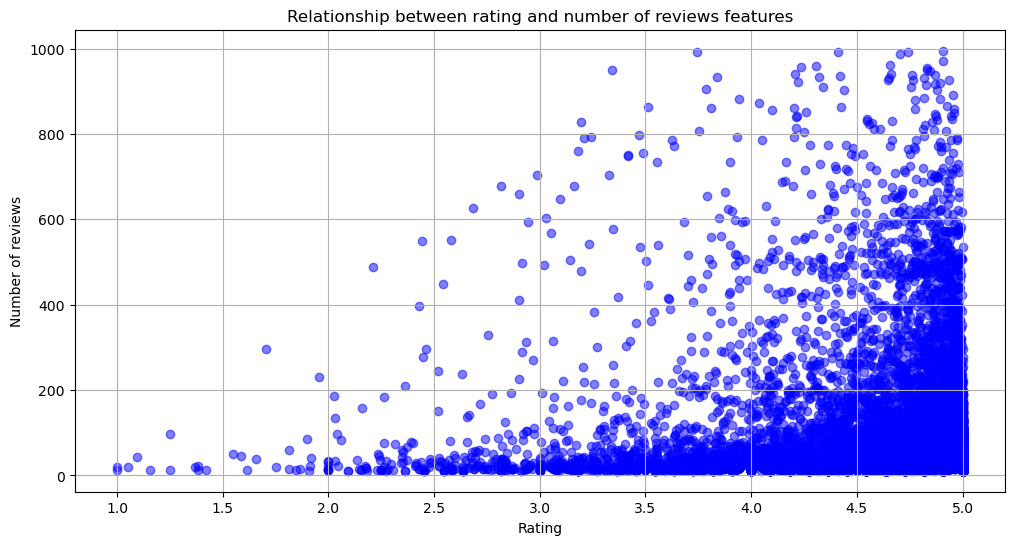

In [26]:
plot_scatter_plot(x_data=df_reviews_filtered[df_reviews_filtered['number_of_reviews'] <= 1000]['rating'],
                    y_data=df_reviews_filtered[df_reviews_filtered['number_of_reviews'] <= 1000]['number_of_reviews'],
                    x_label='Rating',
                    y_label='Number of reviews',
                    title='Relationship between rating and number of reviews features', 
                    alpha=0.5)

It can be seen from the above graph that the average rating of the podcast tends to increase as the number of views increases.

### Podcast category rating value differences based on number of podcasts

On the same principle as before, a relationship between podcast general category mean rating value and the number of podcasts for such category.
To compute pairwise correlation of features, a __Pearson__ (standard correlation coefficient, which is measured of linear correlation between two sets of data) method will be used.

In [27]:
df_categories_overview.head()

,category,mean_rating,number_of_podcasts,number_of_reviews
0,business,4.899177,3099,185965
1,spirituality,4.860415,39,1689
2,education,4.848762,1922,120577
3,religion,4.833693,1485,86850
4,health,4.826575,1544,105844


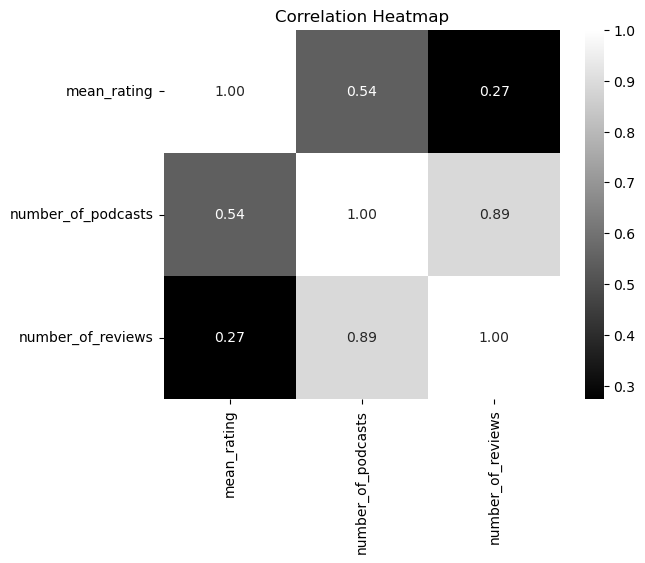

In [28]:
plot_correlation_heatmap(
    correlation_matrix=df_categories_overview.corr()
)

In [29]:
find_corr_pairs(
    data_frame=df_categories_overview.corr(),
    correlation_type='positive_strong'
)

Positive Strong correlated pairs (between 0.6 and 1):
Pair: ['number_of_podcasts', 'number_of_reviews'], score: 0.8916365508622857


In [30]:
find_corr_pairs(
    data_frame=df_categories_overview.corr(),
    correlation_type='positive_moderate'
)

Positive Moderate correlated pairs (between 0.2 and 0.6):
Pair: ['mean_rating', 'number_of_reviews'], score: 0.273642649376549
Pair: ['mean_rating', 'number_of_podcasts'], score: 0.54375172686604


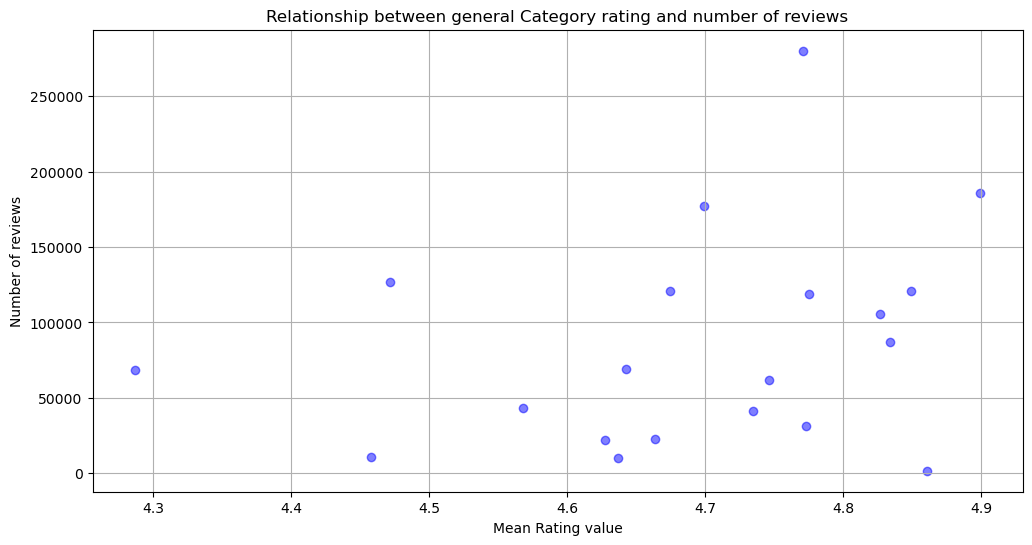

In [31]:
plot_scatter_plot(x_data=df_categories_overview['mean_rating'],
                    y_data=df_categories_overview['number_of_reviews'],
                    x_label='Mean Rating value',
                    y_label='Number of reviews',
                    title='Relationship between general Category rating and number of reviews', 
                    alpha=0.5)

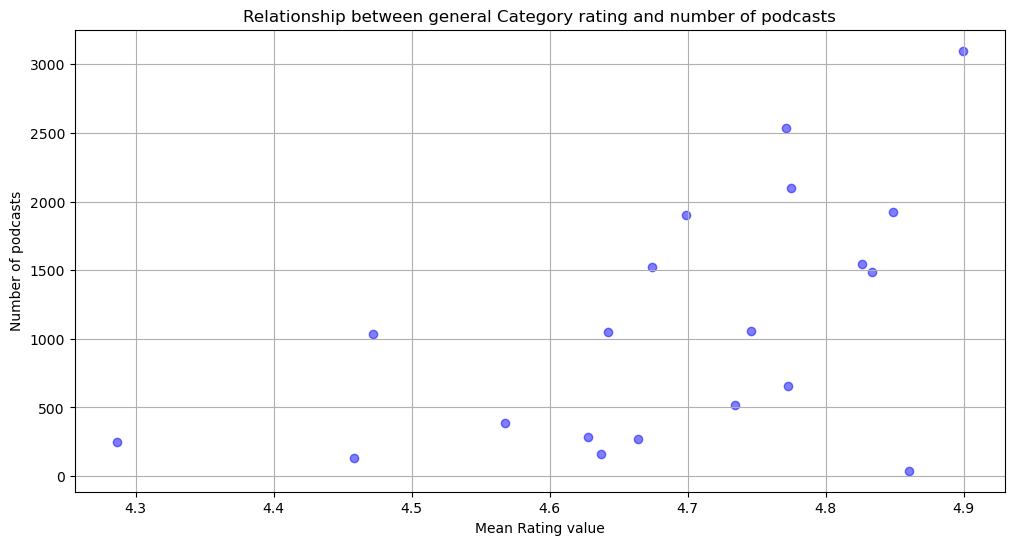

In [32]:
plot_scatter_plot(x_data=df_categories_overview['mean_rating'],
                    y_data=df_categories_overview['number_of_podcasts'],
                    x_label='Mean Rating value',
                    y_label='Number of podcasts',
                    title='Relationship between general Category rating and number of podcasts', 
                    alpha=0.5)

Based to the analysis above, the trend can be noticed, that with a larger amount of reviews or podcasts, the overall rating score of the category tends to increase as well and vice versa, which means that to have a popular and well-reviewed podcast, it is necessary to pay attention to both factors - quality and popularity.

### Statistical Inference

In [33]:
print(f"For this analysis, data filtered in the previous section will be used. "
      f"Dataset containts {len(df_reviews_filtered)} records of different podcasts, "
      f"which overall avarage rating score is {round(df_reviews_filtered['rating'].mean(),4)} "
      f"(standard deviation equal to {round(df_reviews_filtered['rating'].std(),4)}).")

For this analysis, data filtered in the previous section will be used. Dataset containts 21949 records of different podcasts, which overall avarage rating score is 4.7542 (standard deviation equal to 0.4271).


The following table shows the top 5 categories and their mean rating scores. From the following table it can be seen that the mean value is higher than the average value of the entire population, and during further analyzes hypothesis testing will be used to determine whether this apparent difference is statistically significant.

In [34]:
df_reviews_statistics.head(5)

,category,mean,std,count
0,business,4.899177,0.260953,3099
1,spirituality,4.860415,0.284044,39
2,education,4.848762,0.318965,1922
3,religion,4.833693,0.330240,1485
4,health,4.826575,0.352063,1544


__Hypothesis testing will include the following steps__:
1. Define null and alternative hypotheses.
2. Examine data, check assumptions, and calculate test statistic and determine correponding p-value.
4. Make a decision about null hypothesis.

__Parameters mentioned in further analysis__:
* Population_data: ovarall podcasts from the dataset prepared in the previous section.
* Sample_data: podcasts assigned to specific category from the dataset prepared in the previous section.
* Z-statistic: value that measures how many standard deviations an observed sample mean is from the hypothesized population mean. The larger the absolute value of the z-statistic, the more evidence against the null hypothesis.
* P-Value (p): The probability of obtaining the observed result of z-statistic if the null hypothesis is true. If the p-value is less than or equal to established significance level α (p ≤ α), typically the null hypothesis is rejected.


#### Podcasts that are assigned to the business genre category

__Null Hypothesis__ (H0): The average rating score of the podcasts which are classified as business is equal to the average rating score of the overall population: $\mu_1 = \mu_2$

__Alternative Hypothesis__ (Ha): The average rating score of the podcasts which are classified as business is not equal to the average rating score of the overall population: $\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other (ratings for one podcasts are not influenced by or related to the ratings of another podcast within the same sample).

The sample sizes of all top 5 categories podcasts and the overall is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

In [35]:
alpha = 0.05
overall_rating = df_reviews_filtered['rating']
business_rating = df_reviews_filtered[df_reviews_filtered['category'] == 'business']['rating']

In [36]:
perform_z_test(sample_data=business_rating,
       population_data=overall_rating,
       alpha=0.05
      )

Calculated z-statistic value = 18.410049444922304, corresponding p-value = 1.0912290709621098e-75.
Reject the null hypothesis. There is a significant difference between the sample and the population.


__Conclution__: With a p-value less than the 0.05 significance level, we reject the null hypothesis. There is sufficient evidence to support a significant difference between the population mean rating score for podcasts in the business category and the overall mean rating score for podcasts with more than 10 reviews.

In [37]:
business_rating_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=business_rating.mean(),
    sample_std=business_rating.std(),
    sample_size=len(business_rating)
)

In [38]:
print(f'With 95% confidence, the average rating score of podcasts classified as Business genre '
      f'is estimated to fall within the range of {round(business_rating_ci[0],5)} to {round(business_rating_ci[1],5)}. '
      f'This suggests that there is a 95% probability that the true average rating score '
      f'of Business podcasts is within this interval.')

With 95% confidence, the average rating score of podcasts classified as Business genre is estimated to fall within the range of 4.88999 to 4.90836. This suggests that there is a 95% probability that the true average rating score of Business podcasts is within this interval.


#### Podcasts that are assigned to the spirituality genre category

__Null Hypothesis__ (H0): The average rating score of the podcasts which are classified as spirituality is equal to the average rating score of the overall population: $\mu_1 = \mu_2$

__Alternative Hypothesis__ (Ha): The average rating score of the podcasts which are classified as spirituality is not equal to the average rating score of the overall population: $\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other (ratings for one podcasts are not influenced by or related to the ratings of another podcast within the same sample).

The sample sizes of all top 5 categories podcasts and the overall is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

In [39]:
alpha = 0.05
overall_rating = df_reviews_filtered['rating']
spirituality_rating = df_reviews_filtered[df_reviews_filtered['category'] == 'spirituality']['rating']

In [40]:
perform_z_test(sample_data=spirituality_rating,
       population_data=overall_rating,
       alpha=0.05
      )

Calculated z-statistic value = 1.5516588645068432, corresponding p-value = 0.12074387028346223.
Fail to reject the null hypothesis. There is no significant difference between the sample and the population.


__Conclution__: With a p-value greater than the 0.05 significance level, we fail to reject the null hypothesis. There is insufficient evidence to support a significant difference between the sample mean rating score for podcasts in the spirituality category and the overall population mean rating score for podcasts with more than 10 reviews.

In [41]:
spirituality_rating_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=spirituality_rating.mean(),
    sample_std=spirituality_rating.std(),
    sample_size=len(spirituality_rating)
)

In [42]:
print(f'With 95% confidence, the average rating score of podcasts classified as Spirituality genre '
      f'is estimated to fall within the range of {round(spirituality_rating_ci[0],5)} to {round(spirituality_rating_ci[1],5)}. '
      f'This suggests that there is a 95% probability that the true average rating score '
      f'of Spirituality podcasts is within this interval.')

With 95% confidence, the average rating score of podcasts classified as Spirituality genre is estimated to fall within the range of 4.77127 to 4.94956. This suggests that there is a 95% probability that the true average rating score of Spirituality podcasts is within this interval.


#### Podcasts that are assigned to the education genre category

__Null Hypothesis__ (H0): The average rating score of the podcasts which are classified as education is equal to the average rating score of the overall population: $\mu_1 = \mu_2$

__Alternative Hypothesis__ (Ha): The average rating score of the podcasts which are classified as education is not equal to the average rating score of the overall population: $\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other (ratings for one podcasts are not influenced by or related to the ratings of another podcast within the same sample).

The sample sizes of all top 5 categories podcasts and the overall is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

In [43]:
alpha = 0.05
overall_rating = df_reviews_filtered['rating']
education_rating = df_reviews_filtered[df_reviews_filtered['category'] == 'education']['rating']

In [44]:
perform_z_test(sample_data=education_rating,
       population_data=overall_rating,
       alpha=0.05
      )

Calculated z-statistic value = 9.472595060613001, corresponding p-value = 2.7297614898514268e-21.
Reject the null hypothesis. There is a significant difference between the sample and the population.


__Conclution__: With a p-value less than the 0.05 significance level, we reject the null hypothesis. There is sufficient evidence to support a significant difference between the population mean rating score for podcasts in the education category and the overall mean rating score for podcasts with more than 10 reviews.

In [45]:
education_rating_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=education_rating.mean(),
    sample_std=education_rating.std(),
    sample_size=len(education_rating)
)

In [46]:
print(f'With 95% confidence, the average rating score of podcasts classified as Education genre '
      f'is estimated to fall within the range of {round(education_rating_ci[0],5)} to {round(education_rating_ci[1],5)}. '
      f'This suggests that there is a 95% probability that the true average rating score '
      f'of Education podcasts is within this interval.')

With 95% confidence, the average rating score of podcasts classified as Education genre is estimated to fall within the range of 4.8345 to 4.86302. This suggests that there is a 95% probability that the true average rating score of Education podcasts is within this interval.


#### Podcasts that are assigned to the religion genre category

__Null Hypothesis__ (H0): The average rating score of the podcasts which are classified as religion is equal to the average rating score of the overall population: $\mu_1 = \mu_2$

__Alternative Hypothesis__ (Ha): The average rating score of the podcasts which are classified as religion is not equal to the average rating score of the overall population: $\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other (ratings for one podcasts are not influenced by or related to the ratings of another podcast within the same sample).

The sample sizes of all top 5 categories podcasts and the overall is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

In [47]:
alpha = 0.05
overall_rating = df_reviews_filtered['rating']
religion_rating = df_reviews_filtered[df_reviews_filtered['category'] == 'religion']['rating']

In [48]:
perform_z_test(sample_data=religion_rating,
       population_data=overall_rating,
       alpha=0.05
      )

Calculated z-statistic value = 7.027010554377475, corresponding p-value = 2.1100541170656955e-12.
Reject the null hypothesis. There is a significant difference between the sample and the population.


__Conclution__: With a p-value less than the 0.05 significance level, we reject the null hypothesis. There is sufficient evidence to support a significant difference between the population mean rating score for podcasts in the religion category and the overall mean rating score for podcasts with more than 10 reviews.

In [49]:
religion_rating_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=religion_rating.mean(),
    sample_std=religion_rating.std(),
    sample_size=len(religion_rating)
)

In [50]:
print(f'With 95% confidence, the average rating score of podcasts classified as Religion genre '
      f'is estimated to fall within the range of {round(religion_rating_ci[0],5)} to {round(religion_rating_ci[1],5)}. '
      f'This suggests that there is a 95% probability that the true average rating score '
      f'of Religion podcasts is within this interval.')

With 95% confidence, the average rating score of podcasts classified as Religion genre is estimated to fall within the range of 4.8169 to 4.85049. This suggests that there is a 95% probability that the true average rating score of Religion podcasts is within this interval.


#### Podcasts that are assigned to the health genre category

__Null Hypothesis__ (H0): The average rating score of the podcasts which are classified as health is equal to the average rating score of the overall population: $\mu_1 = \mu_2$

__Alternative Hypothesis__ (Ha): The average rating score of the podcasts which are classified as health is not equal to the average rating score of the overall population: $\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other (ratings for one podcasts are not influenced by or related to the ratings of another podcast within the same sample).

The sample sizes of all top 5 categories podcasts and the overall is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

In [51]:
alpha = 0.05
overall_rating = df_reviews_filtered['rating']
health_rating = df_reviews_filtered[df_reviews_filtered['category'] == 'health']['rating']

In [52]:
perform_z_test(sample_data=health_rating,
       population_data=overall_rating,
       alpha=0.05
      )

Calculated z-statistic value = 6.500413195213932, corresponding p-value = 8.009969806829915e-11.
Reject the null hypothesis. There is a significant difference between the sample and the population.


__Conclution__: With a p-value less than the 0.05 significance level, we reject the null hypothesis. There is sufficient evidence to support a significant difference between the population mean rating score for podcasts in the religion category and the overall mean rating score for podcasts with more than 10 reviews.

In [53]:
health_rating_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=health_rating.mean(),
    sample_std=health_rating.std(),
    sample_size=len(health_rating)
)

In [54]:
print(f'With 95% confidence, the average rating score of podcasts classified as Health genre '
      f'is estimated to fall within the range of {round(health_rating_ci[0],5)} to {round(health_rating_ci[1],5)}. '
      f'This suggests that there is a 95% probability that the true average rating score '
      f'of Health podcasts is within this interval.')

With 95% confidence, the average rating score of podcasts classified as Health genre is estimated to fall within the range of 4.80901 to 4.84414. This suggests that there is a 95% probability that the true average rating score of Health podcasts is within this interval.


## User behavior and engagement patterns

In this section, attention will be paid to the timestamp property of writing a review, thus trying to identify user behavior and engagement patterns. This information could help podcast authors to plan the release time of new podcasts so that people's interest and engagement would be maximum.

__Note:__ _In this analysis, it will be evaluated when the comment was written, based on what time it was in the reviewer's time zone, therefore, in order to successfully use the acquired knowledge in the future, it will be necessary to additionally evaluate the target audience and the time zone of their location._

### Data Loading and Preprocessing

Further analysis will require detailed information related to the posting of comments on platforms, so additional features will be created by extracting the necessary information, which will help analyze and to see the situation in different ways.

In [55]:
df_timestamp = pd.read_sql(
    'SELECT r.created_at, r.podcast_id, r.author_id, r.rating, '
    'CASE '
        'WHEN c.category = "true-crime" THEN "true crime" '  
        'WHEN c.category IN ("buddhism", "islam", "christianity", "judaism", "hinduism") THEN "religion" '
        'WHEN c.category LIKE "%-%" THEN SUBSTR(category, 1, INSTR(category, "-")-1) '
        'ELSE c.category '
    'END AS general_category '
    'FROM categories c '
    'LEFT JOIN reviews r on c.podcast_id = r.podcast_id',
    db_connection
)

In [56]:
df_timestamp['created_at'] = pd.to_datetime(df_timestamp['created_at']).dt.tz_localize(None)

df_timestamp = df_timestamp.assign(
    date=df_timestamp['created_at'].dt.date,
    time=df_timestamp['created_at'].dt.time,
    year=df_timestamp['created_at'].dt.year,
    month=df_timestamp['created_at'].dt.month,
    weekday=df_timestamp['created_at'].dt.weekday,
    day=df_timestamp['created_at'].dt.day,
    hour=df_timestamp['created_at'].dt.hour
)

In [57]:
df_timestamp.head()

,created_at,podcast_id,author_id,rating,general_category,date,time,year,month,weekday,day,hour
0,2018-05-09 18:14:32,c61aa81c9b929a66f0c1db6cbe5d8548,F6BF5472689BD12,5,arts,2018-05-09,18:14:32,2018,5,2,9,18
1,2018-04-24 12:05:16,c61aa81c9b929a66f0c1db6cbe5d8548,F7E5A318989779D,5,arts,2018-04-24,12:05:16,2018,4,1,24,12
2,2018-05-09 18:14:32,c61aa81c9b929a66f0c1db6cbe5d8548,F6BF5472689BD12,5,arts,2018-05-09,18:14:32,2018,5,2,9,18
3,2018-04-24 12:05:16,c61aa81c9b929a66f0c1db6cbe5d8548,F7E5A318989779D,5,arts,2018-04-24,12:05:16,2018,4,1,24,12
4,2018-05-09 18:14:32,c61aa81c9b929a66f0c1db6cbe5d8548,F6BF5472689BD12,5,music,2018-05-09,18:14:32,2018,5,2,9,18


### General information about the podcats

In [58]:
print(f"Data on podcasts and reviews in the database are collected and stored from {df_timestamp['date'].min()} to {df_timestamp['date'].max()}.")

Data on podcasts and reviews in the database are collected and stored from 2005-12-09 to 2023-02-16.


Information regarding the number of reviews written by podcast general categories and the change of that number over the years can be seen in the following table and graphic visualization.

__Note:__ _Since the first year of collection and in the last year the data was not collected in full throughout the year, data from these years is not currently used to represent the annual number of reviews._

In [59]:
df_yearly_counts = (
    df_timestamp.groupby(['year', 'general_category'])
    .size()
    .reset_index(name='count')
)
df_yearly_counts = df_yearly_counts.pivot(
    index='general_category',
    columns='year',
    values='count'
).astype(pd.Int64Dtype()).fillna(0)

totals = df_yearly_counts.sum()
df_yearly_counts.loc['Total'] = totals

In [60]:
df_yearly_counts = df_yearly_counts.iloc[:, 1:-1]
df_yearly_counts

year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
general_category,,,,,,,,,,,,,,,,,
arts,1237,2206,2495,2938,2193,3339,4756,4298,6106,10574,15398,23909,29796,41137,44460,37701,20823
business,140,799,702,1031,785,1204,2133,3800,12138,23895,26249,36045,48893,70297,88836,73177,42176
comedy,672,416,701,1232,1722,3223,6880,5862,7090,10735,15652,24691,37926,80213,93991,72528,45228
education,552,1015,1551,1497,1516,1915,3068,2840,5877,12235,13313,21125,31582,59236,84585,70411,44170
fiction,6,15,42,133,247,193,300,322,421,815,3036,5085,6204,9454,13998,13310,8747
government,75,69,48,69,78,86,107,139,108,244,467,1995,2036,2302,3383,2559,1622
health,208,802,1021,1032,1489,1867,2316,2858,4620,9579,11469,18652,33828,60687,73996,65015,44840
history,33,69,117,146,190,158,223,337,558,1371,2142,4800,7439,10920,12164,10949,7054
kids,67,371,460,338,433,455,665,680,1426,2576,3869,5010,10433,27663,46997,37843,29010


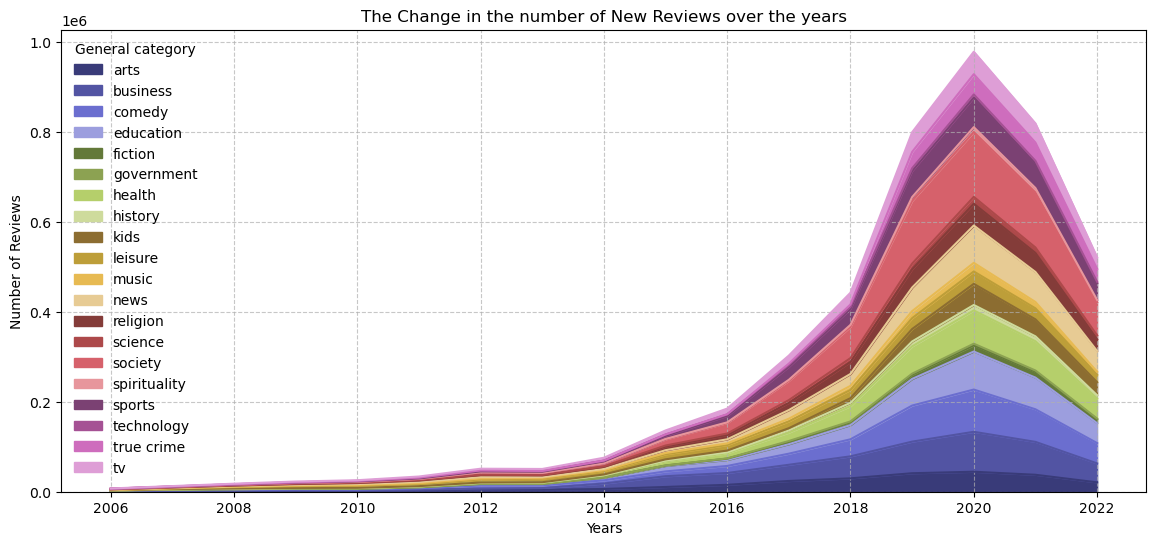

In [61]:
plot_area_stacked(
    data_frame=df_yearly_counts,
    x_label='Years',
    y_label='Number of Reviews',
    title='The Change in the number of New Reviews over the years',
    legend_title='General category'
)

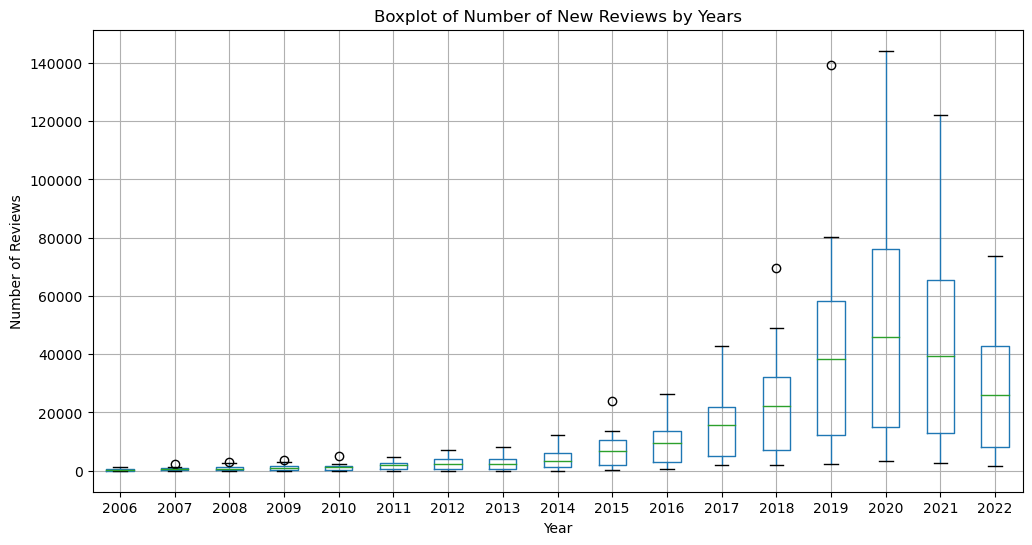

In [62]:
plot_boxplot_distribution(
    data_frame=df_yearly_counts[:-1],
    x_label='Year',
    y_label='Number of Reviews',
    title='Boxplot of Number of New Reviews by Years',
    figsize=(12, 6)
)

In [63]:
df_yearly_counts[:-1].describe()

year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,363.050000,627.900000,893.800000,1134.50000,1279.950000,1692.450000,2559.000000,2531.450000,3779.400000,6814.650000,9245.800000,15143.350000,22137.000000,39982.550000,48935.950000,40961.700000,26076.150000
std,331.489855,539.347452,809.575951,977.64225,1115.084112,1313.207663,2166.111651,2181.478723,3273.625986,6024.814356,7531.729036,11969.108278,17819.445118,33100.498057,37319.639711,30867.760444,19380.514406
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,196.000000,467.000000,1995.000000,2036.000000,2302.000000,3383.000000,2559.000000,1622.000000
25%,73.500000,270.750000,302.500000,308.50000,399.000000,423.500000,603.250000,594.250000,1113.000000,1995.000000,3026.000000,4957.500000,7130.250000,12126.750000,14937.000000,13040.000000,8165.500000
50%,227.000000,557.000000,709.500000,1031.50000,1262.000000,1841.000000,2178.500000,2199.500000,3435.500000,6606.500000,9390.500000,15571.500000,22207.000000,38510.000000,46015.500000,39254.500000,25899.000000
75%,574.500000,882.250000,1241.750000,1610.50000,1719.000000,2588.750000,3862.250000,3924.500000,6158.000000,10614.250000,13614.750000,21821.000000,32143.500000,58327.000000,76253.000000,65448.250000,42674.500000
max,1237.000000,2206.000000,3015.000000,3771.00000,4930.000000,4576.000000,6979.000000,8061.000000,12138.000000,23895.000000,26249.000000,42842.000000,69727.000000,139447.000000,144199.000000,122108.000000,73826.000000


From the visualizations presented above, an increase in activity in 2020 (with the start of the covid pandemic in the world), as well as a decrease in the following years can be seen. 

__Notes:__ 
* It should be noted that the available data includes only information about the review, but not about the podcast itself (author, episode identification number, publication date, etc.).
* Due to changing life habits, the growing role of technology in everyday life, more research and data would be needed to determine activity trends in the future, so this issue will not be investigated further in our analysis.

Despite the decrease in users activity compared to 2020, the activity is increasing over the years, so the analysis will continue to evaluate the activity of users over the course of a day, week, month and year.

### User activity by week days

To evaluate user activity by week days, data regarding new reviews is evaluated yearly. The following graphs and general statistics show the number of new reviews on different days of the week and how it changes over the years.

In [64]:
df_weekday_counts = (
    df_timestamp.groupby(['year', 'weekday'])
    .size()
    .reset_index(name='count')
)

df_weekday_counts = df_weekday_counts.pivot(
    index='year',
    columns='weekday',
    values='count'
).astype(pd.Int64Dtype()).fillna(0)

df_weekday_counts.loc['Total'] = df_weekday_counts.sum()

In [65]:
weekday_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

df_weekday_counts.columns = [weekday_mapping[col] for col in df_weekday_counts.columns]

In [66]:
df_weekday_counts

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
year,,,,,,,
2005,47,62,96,68,61,81,33
2006,964,1193,1159,1248,973,787,937
2007,1797,2033,1807,1954,1759,1541,1667
2008,2708,3069,2762,2599,2203,1987,2548
2009,3440,3671,3553,3596,2723,2658,3049
2010,4120,4068,4011,3945,3405,2780,3270
2011,5166,5448,5366,5073,4509,3812,4475
2012,7951,8075,7849,7960,6897,6005,6443
2013,7680,8342,8049,7979,6848,5794,5937


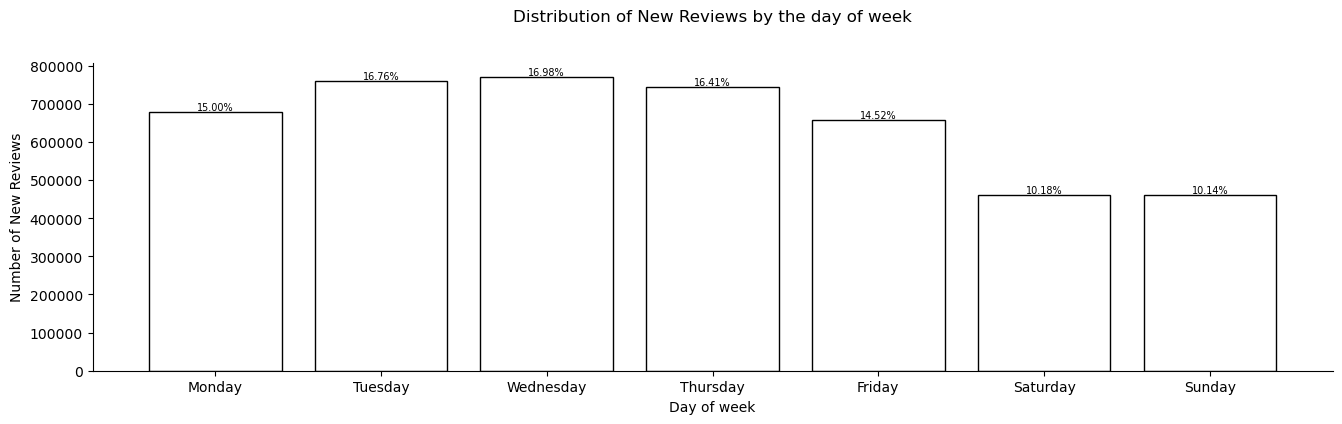

In [67]:
plot_percentage_bars(
    data_frame=df_weekday_counts,
    columns=df_weekday_counts.columns,
    x_label='Day of week',
    y_label='Number of New Reviews',
    title='Distribution of New Reviews by the day of week'
)

The following graph does not include data from 2005 and 2023, as they are not collected from full year.

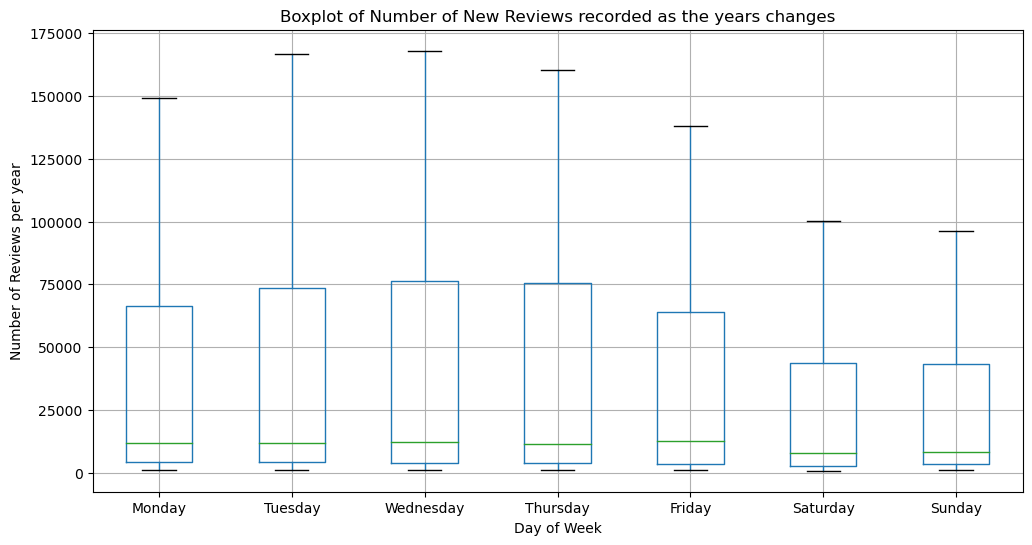

In [68]:
plot_boxplot_distribution(
    data_frame=df_weekday_counts[1:-2], 
    x_label='Day of Week',
    y_label='Number of Reviews per year',
    title='Boxplot of Number of New Reviews recorded as the years changes',
    figsize=(12, 6)
)

In [69]:
df_weekday_counts[1:-2].describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,39517.235294,44185.117647,44791.235294,43310.705882,38338.823529,26868.705882,26704.235294
std,49579.297065,55669.775415,56439.413746,54253.461918,46397.765981,32864.458528,32090.539555
min,964.000000,1193.000000,1159.000000,1248.000000,973.000000,787.000000,937.000000
25%,4120.000000,4068.000000,4011.000000,3945.000000,3405.000000,2780.000000,3270.000000
50%,11628.000000,11953.000000,12247.000000,11352.000000,12676.000000,7676.000000,8056.000000
75%,66336.000000,73479.000000,76376.000000,75390.000000,63838.000000,43876.000000,43445.000000
max,149012.000000,166679.000000,168031.000000,160347.000000,137909.000000,100323.000000,96418.000000


To evaluate the current situation and possible changes, sequential graphs use only full year data from the last five years.

In [70]:
df_weekday_counts_by_year = (
    df_timestamp.groupby(['year', 'weekday'])
    .size()
    .reset_index(name='count')
)

df_weekday_counts_by_year = df_weekday_counts_by_year.pivot(
    index='weekday',
    columns='year',
    values='count'
).astype(pd.Int64Dtype()).fillna(0)

df_weekday_counts_by_year['Total'] = df_weekday_counts_by_year.apply(lambda row: row.sum(), axis=1)

df_weekday_counts_by_year.index = [weekday_mapping[idx] for idx in df_weekday_counts_by_year.index]

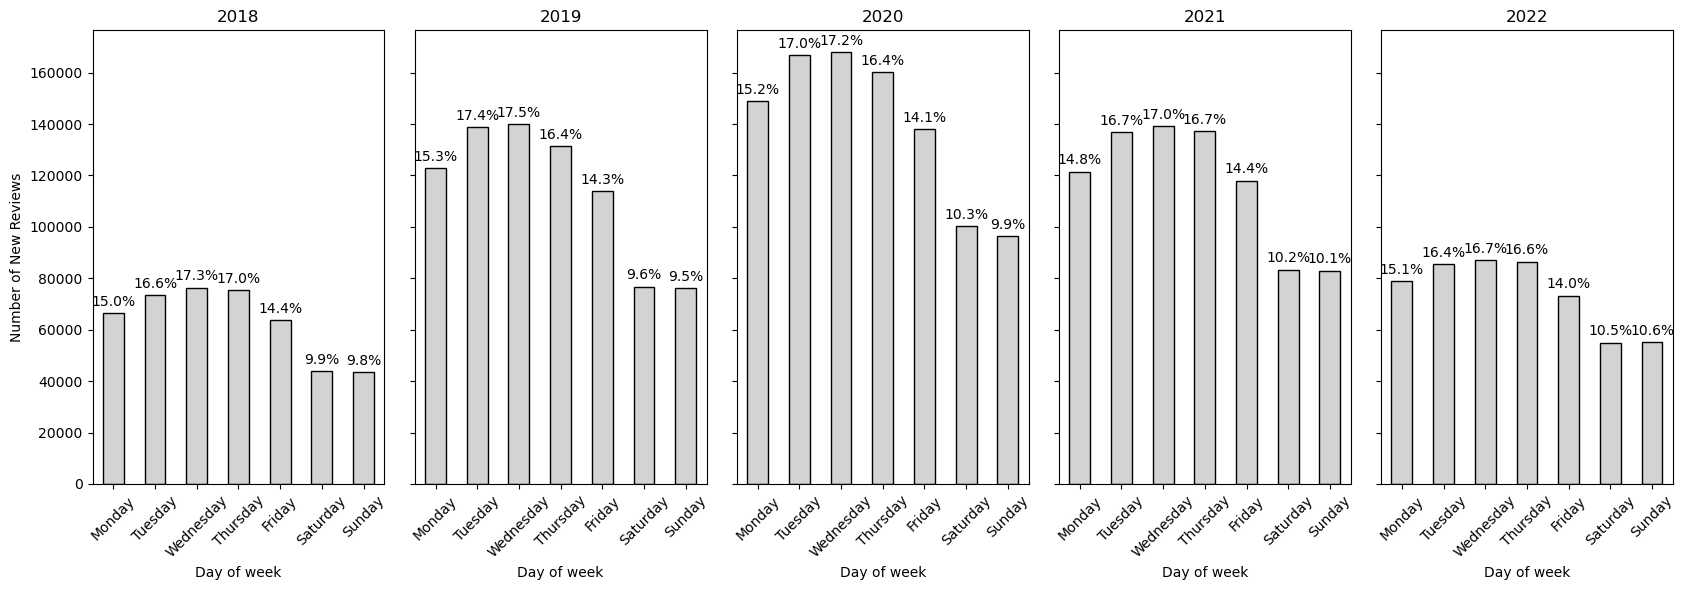

In [71]:
plot_barplot_distribution_by_year(
    data_frame=df_weekday_counts_by_year.iloc[:, -7:-1],
    x_label='Day of week',
    y_label='Number of New Reviews'
)

For further analysis, weekdays are grouped by their type.

__Note:__ _It is assumed that the working week starts from Monday._

In [72]:
df_weekday_counts['workday'] = df_weekday_counts.iloc[:, :5].sum(axis=1)
df_weekday_counts['weekend'] = df_weekday_counts.iloc[:, 5:7].sum(axis=1)


df_weekday_counts_by_type = df_weekday_counts[['workday', 'weekend']]

transposed_df_weekday_counts_by_type = df_weekday_counts_by_type.T

In [73]:
transposed_df_weekday_counts_by_type

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Total
workday,334.0,5537.0,9350.0,13341.0,16983.0,19549.0,25562.0,38732.0,38898.0,59856.0,107840.0,146963.0,241674.0,355419.0,646698.0,781978.0,652834.0,411219.0,35946.0,3608713.0
weekend,114.0,1724.0,3208.0,4535.0,5707.0,6050.0,8287.0,12448.0,11731.0,15732.0,28453.0,37953.0,61193.0,87321.0,152953.0,196741.0,166400.0,110304.0,9916.0,920770.0


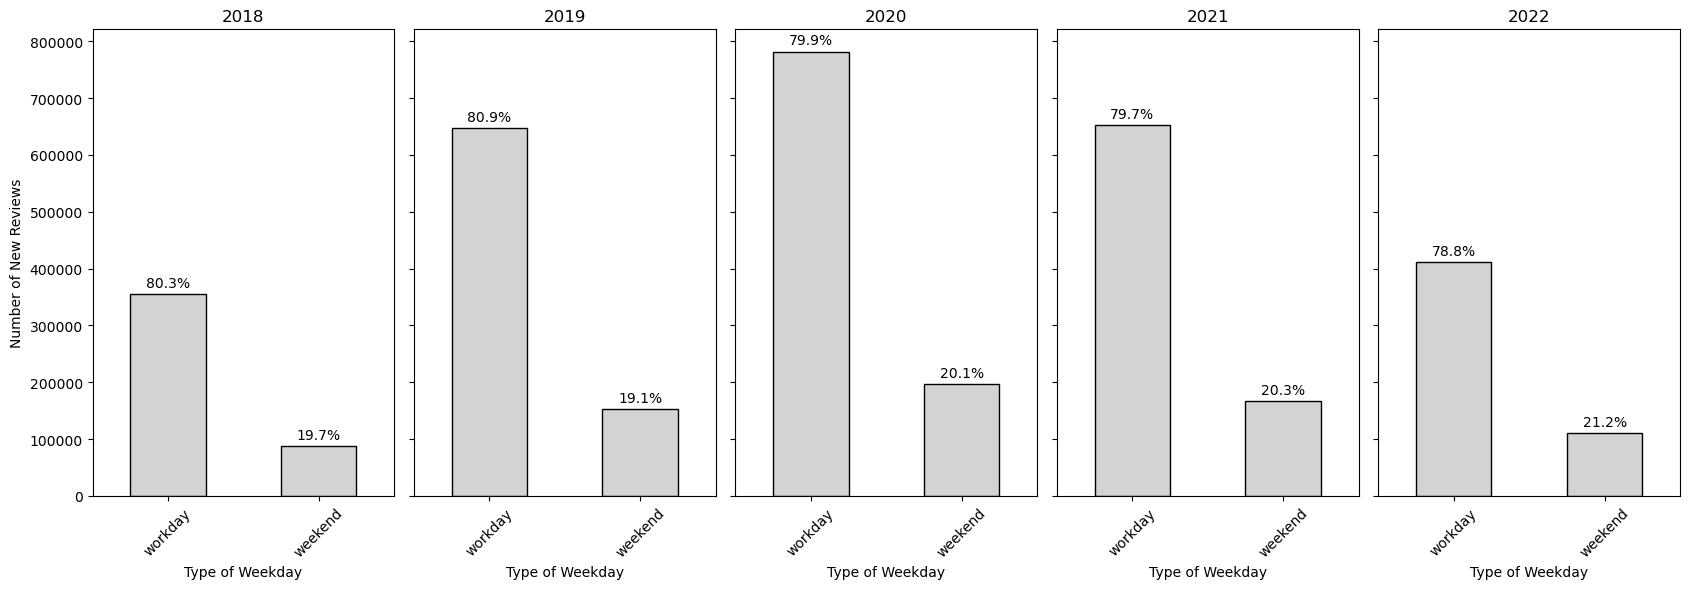

In [74]:
plot_barplot_distribution_by_year(
    data_frame=transposed_df_weekday_counts_by_type.iloc[:, -7:-1],
    x_label='Type of Weekday',
    y_label='Number of New Reviews'
)

#### Statistical Inference

From the analysis above, it can be seen that a large part of reviews are written on workdays. In the next step, using hypothesis testing and a two-sample t-test, it will be checked whether the mean number of reviews written during the working day is statistically significant compared to reviews written during the weekend.

__Note:__ _Data for analysis will be used collected only during the last five years and since daily average values will be evaluated, data from 2023 will also be used._ 

__Null Hypothesis__ (H0): The average number of reviews written on a workday is equal to the average number of reviews written during the weekend:

$\mu_1= \mu_2$

__Alternative Hypothesis__ (Ha): The average number of reviews written on a workday is not equal to the average number of reviews written during the weekend:

$\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other.

The sample sizes of each type of weekday is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

For further analysis, two data sets are prepared, which contain data on the number of reviews per day, by day type.

In [75]:
workday_reviews = (
    df_timestamp[df_timestamp['year'] >= 2019]
    .loc[df_timestamp['weekday'].between(0, 4)]
    .groupby(['date', 'weekday'])
    .size()
    .reset_index(name='count')
)

weekend_reviews = (
    df_timestamp[df_timestamp['year'] >= 2019]
    .loc[df_timestamp['weekday'].between(5, 6)]
    .groupby(['date', 'weekday'])
    .size()
    .reset_index(name='count')
)

In [76]:
perform_two_sample_t_test(
    sample_data_1 = workday_reviews['count'],
    sample_data_2 = weekend_reviews['count'],
    alpha = 0.05
)

Calculated t-statistic value = 22.37177863990812, corresponding p-value = 6.021419898232997e-96.
Reject the null hypothesis. There is a significant difference between the means of two sample data.


__Conclution__: With a p-value less than the 0.05 significance level (in our case, it is so extremely low that it is shown as zero), we reject the null hypothesis. There is sufficient evidence to support a significant difference between the average number of reviews written on workday and the average number of reviews written during the weekend,  based on a data collected since 2019.

In [77]:
workday_reviews_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=workday_reviews['count'].mean(),
    sample_std=workday_reviews['count'].std(),
    sample_size=len(workday_reviews['count'])
)

weekend_reviews_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=weekend_reviews['count'].mean(),
    sample_std=weekend_reviews['count'].std(),
    sample_size=len(weekend_reviews['count'])
)

In [78]:
print(f'Based on a data collected from the 2019, '
      f'with 95% confidence, the average number of reviews written per day for workday '
      f'is estimated to fall within the range of {int(workday_reviews_ci[0])} to {int(workday_reviews_ci[1])}, '
      f'meanwhile for weekend is estimated to fall within the range of {int(weekend_reviews_ci[0])} to {int(weekend_reviews_ci[1])}. '
      f'This suggests that there is a 95% probability that the true average number of new reviews per workday '
      f'and weekend is within these intervals.')

Based on a data collected from the 2019, with 95% confidence, the average number of reviews written per day for workday is estimated to fall within the range of 2300 to 2390, meanwhile for weekend is estimated to fall within the range of 1438 to 1521. This suggests that there is a 95% probability that the true average number of new reviews per workday and weekend is within these intervals.


### User activity by hour per days

To evaluate user activity by hour per day, data regarding new comments is evaluated yearly. The following graphs and general statistics show the number of new reviews on different hour of the day and how it changes over the years.

In [79]:
df_hour_counts = (
    df_timestamp.groupby(['year', 'hour'])
    .size()
    .reset_index(name='count')
)

df_hour_counts = df_hour_counts.pivot(
    index='year',
    columns='hour',
    values='count'
).astype(pd.Int64Dtype()).fillna(0)

df_hour_counts.loc['Total'] = df_hour_counts.sum()

In [80]:
df_hour_counts.tail()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
year,,,,,,,,,,,,,,,,,,,,,
2020,10887,8279,8189,12874,22823,34178,46813,56935,61228,62226,...,53686,50109,49466,48784,50771,48071,41119,32318,23598,15545
2021,7825,6379,7360,11777,20548,31590,41225,48495,52159,52379,...,45191,42207,40424,40702,42015,39611,33407,25666,17849,11800
2022,5493,4468,5164,8972,14395,21187,27201,31655,34054,33529,...,27832,25927,25002,25470,26053,24606,20847,16142,11346,7617
2023,497,428,451,743,1359,1883,2456,2605,2762,3107,...,2247,2307,2093,2277,2401,2275,1824,1361,934,612
Total,48895,38293,40407,64959,109976,165707,219962,260678,283507,285277,...,246413,231403,226525,229643,236853,225893,192845,150669,107067,72465


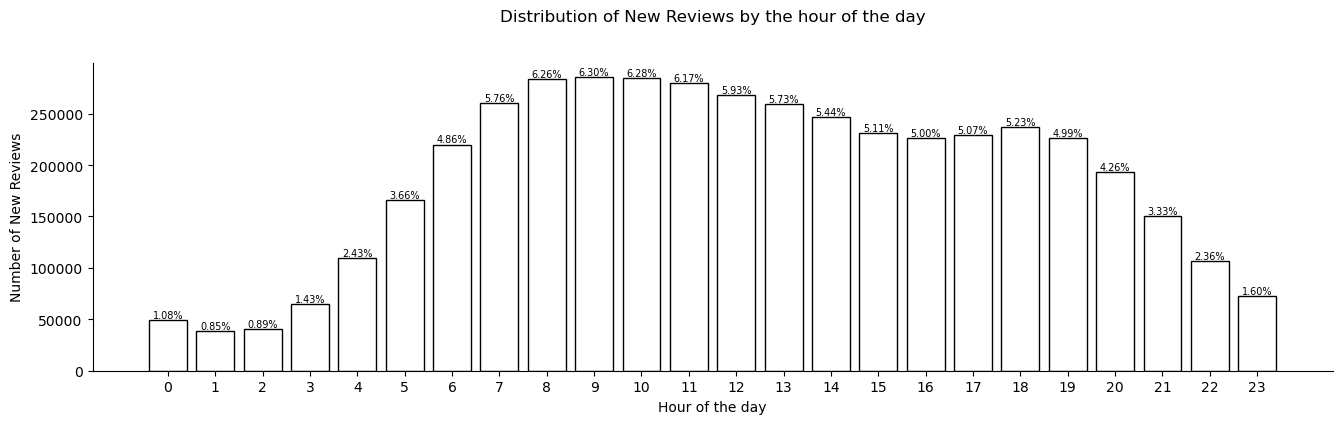

In [81]:
plot_percentage_bars(
    data_frame=df_hour_counts,
    columns=df_hour_counts.columns,
    x_label='Hour of the day',
    y_label='Number of New Reviews',
    title='Distribution of New Reviews by the hour of the day'
)

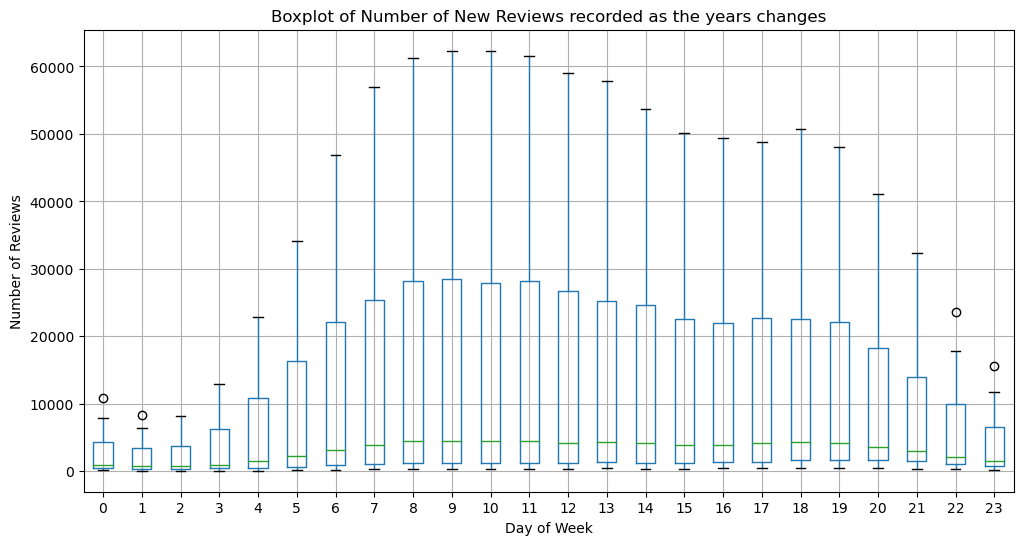

In [82]:
plot_boxplot_distribution(
    data_frame=df_hour_counts[1:-2], 
    x_label='Day of Week',
    y_label='Number of Reviews',
    title='Boxplot of Number of New Reviews recorded as the years changes',
    figsize=(12, 6)
)

In [83]:
df_hour_counts[1:-2].describe()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,2846.176471,2227.235294,2350.058824,3777.058824,6388.941176,9636.588235,12794.000000,15179.647059,16513.882353,16596.764706,...,14361.941176,13474.941176,13200.176471,13372.882353,13789.294118,13152.352941,11233.705882,8781.764706,6242.411765,4224.764706
std,3310.400320,2586.702160,2776.656903,4659.039513,8184.479271,12363.406853,16322.758747,19455.210725,20903.819376,21121.042267,...,17961.859221,16735.268568,16308.185200,16331.339324,16769.045127,15773.244078,13276.501110,10282.711890,7270.849349,4810.933700
min,150.000000,82.000000,84.000000,82.000000,107.000000,178.000000,203.000000,314.000000,343.000000,371.000000,...,361.000000,397.000000,436.000000,412.000000,462.000000,471.000000,446.000000,355.000000,295.000000,213.000000
25%,554.000000,388.000000,345.000000,413.000000,541.000000,615.000000,908.000000,1145.000000,1176.000000,1171.000000,...,1181.000000,1264.000000,1323.000000,1447.000000,1686.000000,1622.000000,1674.000000,1502.000000,1020.000000,789.000000
50%,972.000000,773.000000,769.000000,995.000000,1506.000000,2265.000000,3162.000000,3934.000000,4472.000000,4503.000000,...,4194.000000,3905.000000,3953.000000,4149.000000,4331.000000,4186.000000,3611.000000,2934.000000,2142.000000,1514.000000
75%,4396.000000,3428.000000,3770.000000,6316.000000,10885.000000,16415.000000,22061.000000,25415.000000,28181.000000,28516.000000,...,24580.000000,22616.000000,21945.000000,22708.000000,22497.000000,22147.000000,18290.000000,13969.000000,9941.000000,6624.000000
max,10887.000000,8279.000000,8189.000000,12874.000000,22823.000000,34178.000000,46813.000000,56935.000000,61228.000000,62226.000000,...,53686.000000,50109.000000,49466.000000,48784.000000,50771.000000,48071.000000,41119.000000,32318.000000,23598.000000,15545.000000


As before, to evaluate the current situation and possible changes, sequential graphs use only full year data from the last five years. Also, due to more objective further analyses, the hours will be grouped into three groups.

In [84]:
df_hour_counts['0-8'] = df_hour_counts.iloc[:, 0:9].sum(axis=1)
df_hour_counts['8-16'] = df_hour_counts.iloc[:, 9:17].sum(axis=1)
df_hour_counts['16-0'] = df_hour_counts.iloc[:, 17:24].sum(axis=1)

df_hour_counts_grouped = df_hour_counts[['0-8', '8-16', '16-0']]

transposed_df_hour_counts = df_hour_counts_grouped.T

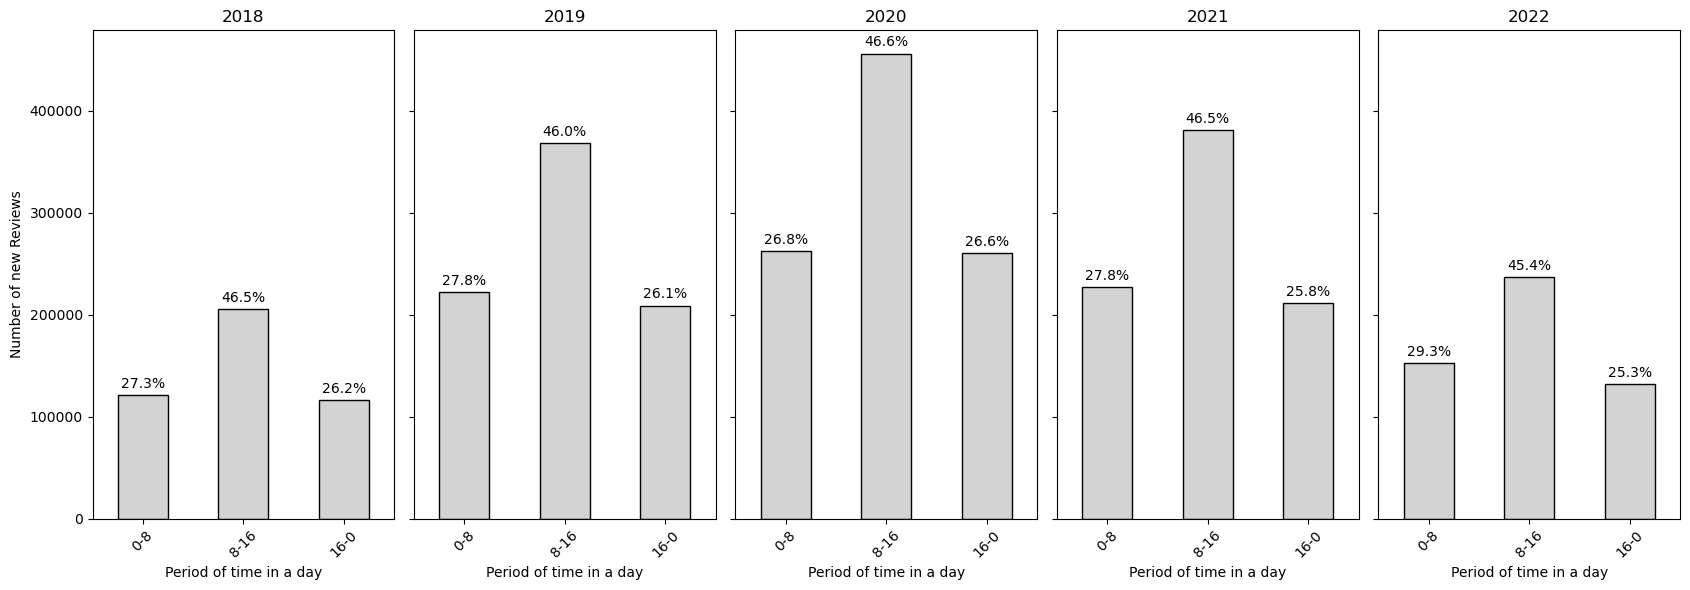

In [85]:
plot_barplot_distribution_by_year(
    data_frame=transposed_df_hour_counts.iloc[:, -7:-1],
    x_label='Period of time in a day',
    y_label='Number of new Reviews'
)

#### Statistical Inference

From the analysis above, it can be seen that a large part of reviews are written between 08:00 and 16:00. In the next step, using hypothesis testing and a two-sample t-test, it will be checked whether the mean number of reviews written hourly in the hours between 08:00 and 16:00 is statistically significant compared to reviews written during the remaining hours of the day.

__Note:__ _Data for analysis will be used collected only during the last five years and since average values per hour will be evaluated, data from 2023 will also be used._ 

__Null Hypothesis__ (H0): The average number of reviews written per hour in the hours between 08:00 and 16:00 is equal to the average number of reviews written per hour during the remaining hours of the day:

$\mu_1= \mu_2$

__Alternative Hypothesis__ (Ha): The average number of reviews written per hour in the hours between 08:00 and 16:00 is not equal to the average number of reviews written per hour during the remaining hours of the day:

$\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other.

The sample sizes of each type of weekday is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

For further analysis, two data sets are prepared, which contain data on the number of reviews per hour, by period of time in a day.

In [86]:
reviews_between_8_and_16 = (
    df_timestamp[df_timestamp['year'] >= 2019]
    .loc[df_timestamp['hour'].between(8, 16)]
    .groupby(['date', 'hour'])
    .size()
    .reset_index(name='count')
)

reviews_except_between_8_and_16 = (
    df_timestamp[df_timestamp['year'] >= 2019]
    .loc[df_timestamp['hour'].between(0, 7) | df_timestamp['hour'].between(16, 23)]
    .groupby(['date', 'hour'])
    .size()
    .reset_index(name='count')
)

In [87]:
perform_two_sample_t_test(
    sample_data_1 = reviews_between_8_and_16['count'],
    sample_data_2 = reviews_except_between_8_and_16['count'],
    alpha = 0.05
)

Calculated t-statistic value = 97.41116432566973, corresponding p-value = 0.0.
Reject the null hypothesis. There is a significant difference between the means of two sample data.


__Conclution__: With a p-value less than the 0.05 significance level (in our case, it is so extremely low that it is shown as zero), we reject the null hypothesis. There is sufficient evidence to support a significant difference between the average number of reviews written per hour in the period of time between 08:00 and 16:00 and the average number of reviews written per hour during the remaining hours of the day, based on a data collected since 2019.

In [88]:
reviews_between_8_and_16_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=reviews_between_8_and_16['count'].mean(),
    sample_std=reviews_between_8_and_16['count'].std(),
    sample_size=len(reviews_between_8_and_16['count'])
)

reviews_except_between_8_and_16_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=reviews_except_between_8_and_16['count'].mean(),
    sample_std=reviews_except_between_8_and_16['count'].std(),
    sample_size=len(reviews_except_between_8_and_16['count'])
)

In [89]:
print(f'Based on a data  collected from the 2019, '
      f'with 95% confidence, the average number of reviews written per hour in the period of time between 08:00 and 16:00 '
      f'is estimated to fall within the range of {int(reviews_between_8_and_16_ci[0])} to {int(reviews_between_8_and_16_ci[1])}. '
      f'For the remaining hours of the day, the average number of reviews is estimated to fall within the range of '
      f' {int(reviews_except_between_8_and_16_ci[0])} to {int(reviews_except_between_8_and_16_ci[1])}. '
      f'This suggests that there is a 95% probability that the true average number of new reviews per hour '
      f'for the mentioned time periods are within these intervals.')

Based on a data  collected from the 2019, with 95% confidence, the average number of reviews written per hour in the period of time between 08:00 and 16:00 is estimated to fall within the range of 121 to 123. For the remaining hours of the day, the average number of reviews is estimated to fall within the range of  68 to 69. This suggests that there is a 95% probability that the true average number of new reviews per hour for the mentioned time periods are within these intervals.


### User activity by day of the month

To evaluate user activity by day of the month, data regarding new comments is evaluated yearly. The following graphs and general statistics show the number of new reviews on different day of the day and how it changes over the years.

In [90]:
df_day_counts = (
    df_timestamp.groupby(['year', 'day'])
    .size()
    .reset_index(name='count')
)

df_day_counts = df_day_counts.pivot(
    index='year',
    columns='day',
    values='count'
).astype(pd.Int64Dtype()).fillna(0)

df_day_counts.loc['Total'] = df_day_counts.sum()

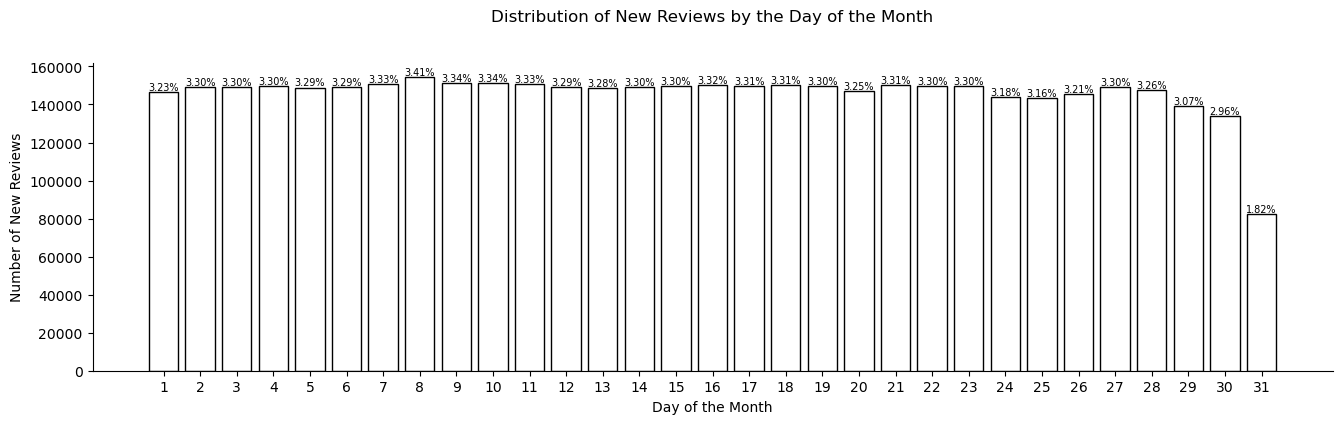

In [91]:
plot_percentage_bars(
    data_frame=df_day_counts,
    columns=df_day_counts.columns,
    x_label='Day of the Month',
    y_label='Number of New Reviews',
    title='Distribution of New Reviews by the Day of the Month'
)

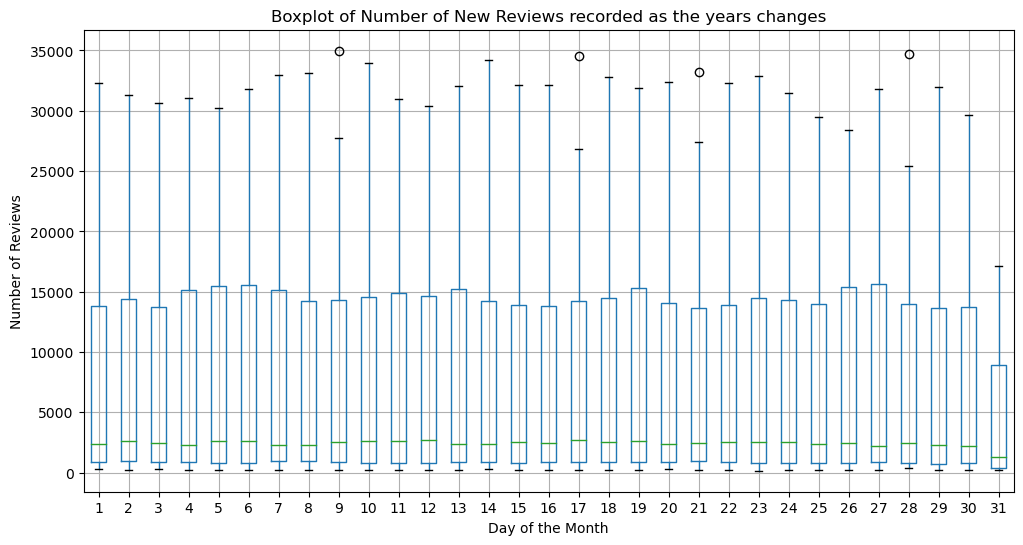

In [92]:
plot_boxplot_distribution(
    data_frame=df_day_counts[1:-2], 
    x_label='Day of the Month',
    y_label='Number of Reviews',
    title='Boxplot of Number of New Reviews recorded as the years changes',
    figsize=(12, 6)
)

In [93]:
pd.set_option('display.max_columns', None)

df_day_counts[1:-2].describe()

day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.00000,17.000000,17.000000
mean,8507.176471,8651.294118,8649.352941,8676.176471,8638.294118,8645.235294,8766.647059,8959.235294,8786.470588,8777.941176,8768.941176,8669.000000,8638.529412,8694.235294,8723.058824,8775.705882,8728.529412,8742.705882,8735.941176,8576.882353,8781.529412,8745.529412,8708.117647,8400.411765,8353.764706,8482.764706,8726.117647,8651.294118,8139.00000,7828.176471,4788.000000
std,10616.574708,10699.057311,10678.242534,10778.063580,10563.211892,10561.966143,10822.131710,11279.481845,11165.455724,10971.419795,10804.223147,10599.176118,10637.578085,10939.769973,10983.313773,11049.041592,10961.653189,10836.826794,10742.645371,10574.953539,11004.566462,10984.136255,11021.157153,10450.705024,10337.421188,10410.507982,10748.012659,10764.405016,10115.80915,9729.637463,5799.060032
min,284.000000,254.000000,274.000000,252.000000,253.000000,226.000000,244.000000,232.000000,221.000000,230.000000,194.000000,234.000000,201.000000,270.000000,187.000000,219.000000,230.000000,234.000000,207.000000,278.000000,232.000000,183.000000,164.000000,244.000000,250.000000,248.000000,217.000000,354.000000,234.00000,220.000000,190.000000
25%,860.000000,943.000000,860.000000,874.000000,835.000000,798.000000,929.000000,948.000000,914.000000,820.000000,838.000000,838.000000,891.000000,849.000000,810.000000,852.000000,852.000000,853.000000,891.000000,875.000000,935.000000,899.000000,839.000000,812.000000,770.000000,792.000000,849.000000,798.000000,715.00000,781.000000,425.000000
50%,2397.000000,2630.000000,2431.000000,2334.000000,2638.000000,2666.000000,2312.000000,2292.000000,2543.000000,2593.000000,2587.000000,2672.000000,2416.000000,2403.000000,2565.000000,2492.000000,2680.000000,2541.000000,2649.000000,2419.000000,2444.000000,2566.000000,2505.000000,2554.000000,2339.000000,2431.000000,2234.000000,2482.000000,2277.00000,2214.000000,1282.000000
75%,13834.000000,14399.000000,13720.000000,15128.000000,15435.000000,15552.000000,15146.000000,14222.000000,14292.000000,14559.000000,14921.000000,14639.000000,15240.000000,14193.000000,13905.000000,13836.000000,14258.000000,14440.000000,15336.000000,14075.000000,13641.000000,13877.000000,14441.000000,14305.000000,13950.000000,15426.000000,15644.000000,14017.000000,13660.00000,13708.000000,8941.000000
max,32330.000000,31293.000000,30672.000000,31063.000000,30256.000000,31838.000000,33002.000000,33164.000000,34976.000000,33991.000000,31009.000000,30365.000000,32043.000000,34180.000000,32124.000000,32130.000000,34507.000000,32773.000000,31916.000000,32345.000000,33250.000000,32274.000000,32850.000000,31473.000000,29444.000000,28423.000000,31808.000000,34666.000000,31981.00000,29684.000000,17153.000000


As before, to evaluate the current situation and possible changes, sequential graphs use only full year data from the last five years. Also, due to more objective further analyses, the days will be grouped into three groups.

In [94]:
df_day_counts['1-10'] = df_day_counts.iloc[:, 0:10].sum(axis=1)
df_day_counts['11-20'] = df_day_counts.iloc[:, 10:20].sum(axis=1)
df_day_counts['21-31'] = df_day_counts.iloc[:, 20:31].sum(axis=1)

df_day_counts_grouped = df_day_counts[['1-10', '11-20', '21-31']]

transposed_df_day_counts = df_day_counts_grouped.T

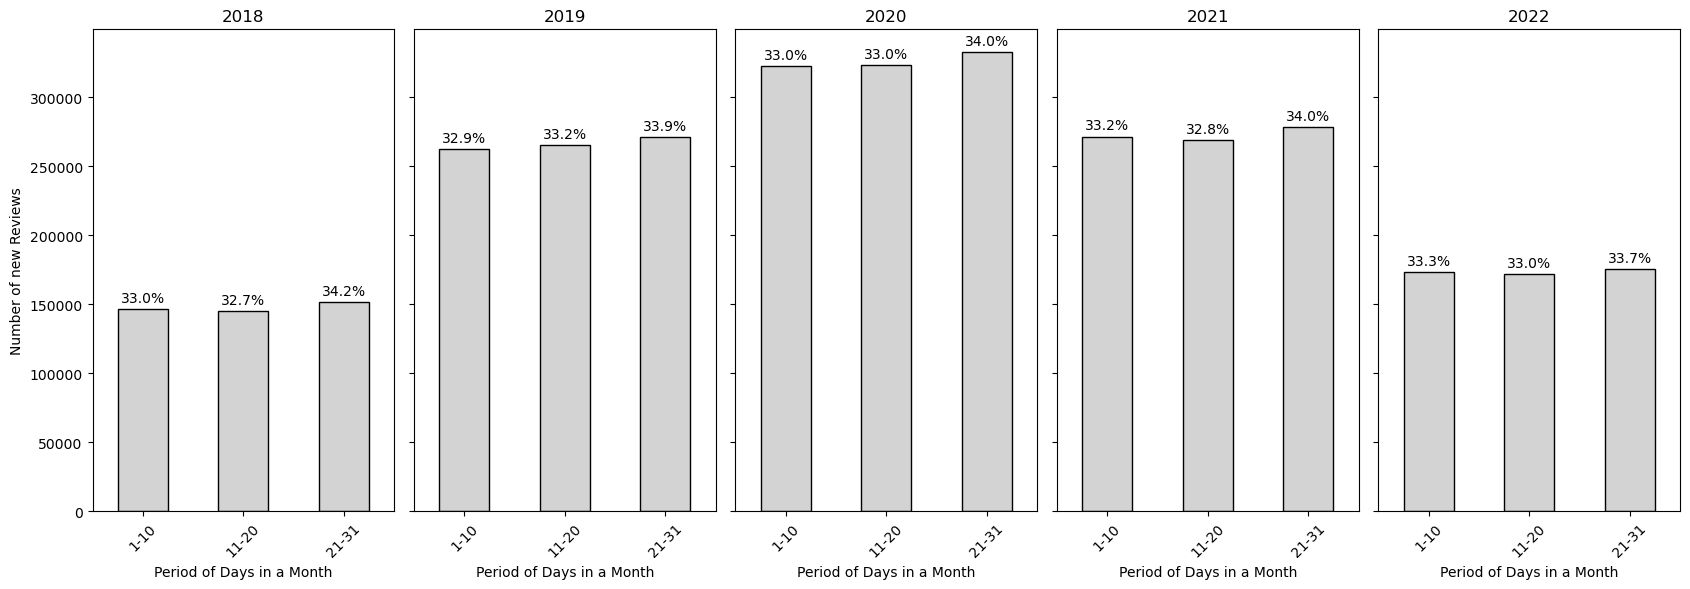

In [95]:
plot_barplot_distribution_by_year(
    data_frame=transposed_df_day_counts.iloc[:, -7:-1],
    x_label='Period of Days in a Month',
    y_label='Number of new Reviews'
)

#### Statistical Inference

From the analysis above, it can be seen that slightly, however, a higher activity regarding new reviews is still recorded in the last third of the month. In the next step, using hypothesis testing and a two-sample t-test, it will be checked whether the mean number of reviews written per day in the period between 21 and 31 days is statistically significant compared to reviews written during the remaining period of the month.

__Note:__ _Data for analysis will be used collected only during the last five years and since average values per day will be evaluated, data from 2023 will also be used._ 

__Null Hypothesis__ (H0): The average number of reviews written per day in the period of days in a month between 21 and 31 is equal to the average number of reviews written per day during the remaining period of the month:

$\mu_1= \mu_2$

__Alternative Hypothesis__ (Ha): The average number of reviews written per day in the period of days in a month between 21 and 31 is not equal to the average number of reviews written per day during the remaining period of the month:

$\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other.

The sample sizes of each type of weekday is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

For further analysis, two data sets are prepared, which contain data on the number of reviews per day, by period of the month.

In [96]:
reviews_between_21_and_31 = (
    df_timestamp[df_timestamp['year'] >= 2019]
    .loc[df_timestamp['day'].between(21, 31)]
    .groupby(['date', 'day'])
    .size()
    .reset_index(name='count')
)

reviews_between_1_and_20 = (
    df_timestamp[df_timestamp['year'] >= 2019]
    .loc[df_timestamp['day'].between(1, 20)]
    .groupby(['date', 'day'])
    .size()
    .reset_index(name='count')
)

In [97]:
perform_two_sample_t_test(
    sample_data_1 = reviews_between_21_and_31['count'],
    sample_data_2 = reviews_between_1_and_20['count'],
    alpha = 0.05
)

Calculated t-statistic value = -0.36047749051841904, corresponding p-value = 0.7185406381258848.
Fail to reject the null hypothesis. There is no significant difference between the means of two sample data.


__Conclution__: With a p-value greater than the 0.05 significance level, we fail to reject the null hypothesis. There is insufficient evidence to support a significant difference between the average number of reviews written per day in the period of days in a month between 21 and 31 and the average number of reviews written per day during the remaining period of the month, based on a data collected since 2019.

In [98]:
reviews_between_21_and_31_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=reviews_between_21_and_31['count'].mean(),
    sample_std=reviews_between_21_and_31['count'].std(),
    sample_size=len(reviews_between_21_and_31['count'])
)

reviews_except_between_1_and_20_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=reviews_between_1_and_20['count'].mean(),
    sample_std=reviews_between_1_and_20['count'].std(),
    sample_size=len(reviews_between_1_and_20['count'])
)

In [99]:
print(f'Based on a data  collected from the 2019, '
      f'with 95% confidence, the average number of reviews written per day for the period from the 21st to the 31st of the month '
      f'is estimated to fall within the range of {int(reviews_between_21_and_31_ci[0])} to {int(reviews_between_21_and_31_ci[1])}, '
      f'while for the remaining days of the month, it is estimated to fall within the range of {int(reviews_except_between_1_and_20_ci[0])} '
      f'to {int(reviews_except_between_1_and_20_ci[1])}. '
      f'This suggests that we are 95% confident that the true average number of new reviews per day '
      f' for the mentioned time periods falls within these intervals.')

Based on a data  collected from the 2019, with 95% confidence, the average number of reviews written per day for the period from the 21st to the 31st of the month is estimated to fall within the range of 2019 to 2157, while for the remaining days of the month, it is estimated to fall within the range of 2055 to 2152. This suggests that we are 95% confident that the true average number of new reviews per day  for the mentioned time periods falls within these intervals.


### User activity by month of the year

To evaluate user activity by month of the year, data regarding new comments is evaluated yearly. The following graphs and general statistics show the number of new reviews on different month of the year and how it changes over the years.

In [100]:
df_month_counts = (
    df_timestamp.groupby(['year', 'month'])
    .size()
    .reset_index(name='count')
)

df_month_counts = df_month_counts.pivot(
    index='year',
    columns='month',
    values='count'
).astype(pd.Int64Dtype()).fillna(0)

df_month_counts.loc['Total'] = df_month_counts.sum()

In [101]:
months_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df_month_counts.columns = [months_mapping[col] for col in df_month_counts.columns]

In [102]:
df_month_counts.head()

,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2005,0,0,0,0,0,0,0,0,0,0,0,448
2006,826,689,628,560,585,503,570,575,618,789,456,462
2007,918,1115,1065,1031,974,1030,1106,1049,1075,1143,1029,1023
2008,1505,1453,1546,1543,1474,1571,1765,1541,1738,1316,1177,1247
2009,1813,1849,1867,1519,1640,1534,2222,2283,2102,2139,1855,1867


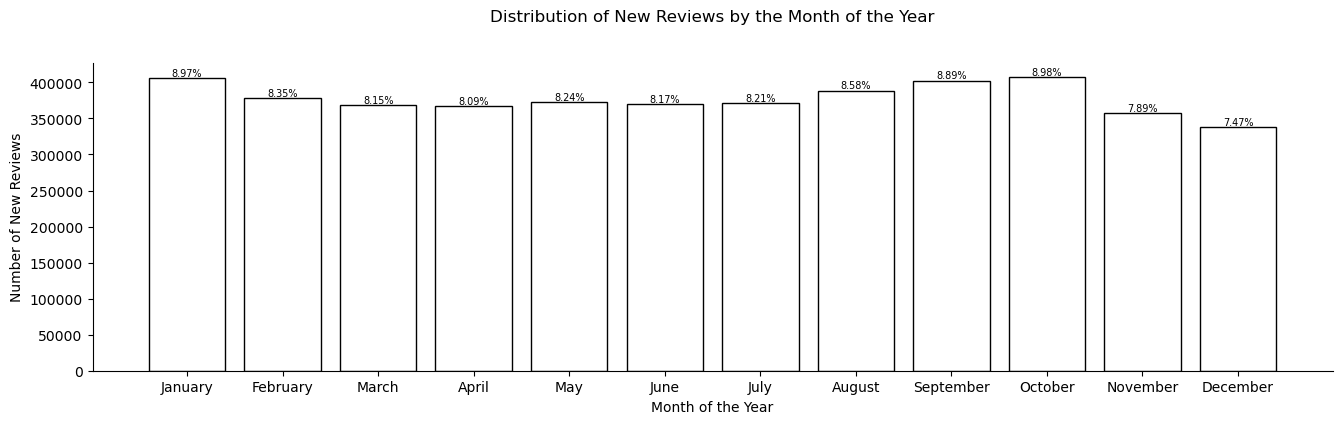

In [103]:
plot_percentage_bars(
    data_frame=df_month_counts,
    columns=df_month_counts.columns,
    x_label='Month of the Year',
    y_label='Number of New Reviews',
    title='Distribution of New Reviews by the Month of the Year'
)

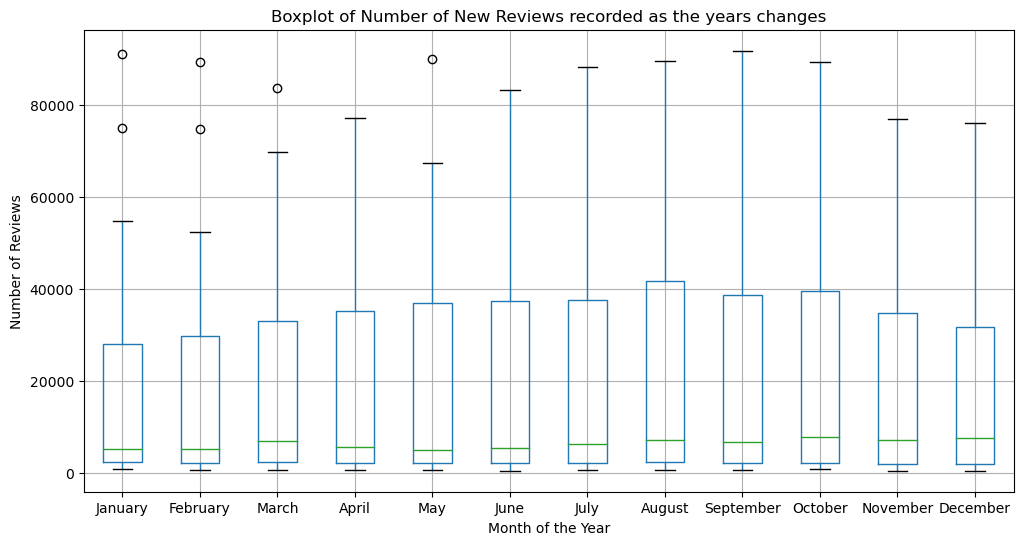

In [104]:
plot_boxplot_distribution(
    data_frame=df_month_counts[1:-2], 
    x_label='Month of the Year',
    y_label='Number of Reviews',
    title='Boxplot of Number of New Reviews recorded as the years changes',
    figsize=(12, 6)
)

In [105]:
df_month_counts[1:-2].describe()

,January,February,March,April,May,June,July,August,September,October,November,December
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,21906.235294,21545.882353,21711.588235,21564.529412,21952.764706,21776.117647,21877.352941,22866.823529,23684.411765,23939.235294,21022.647059,19868.470588
std,28850.474241,28058.014517,26891.755407,26905.147352,28057.550182,27406.417246,27392.857942,28236.509636,30030.004566,29515.470567,26170.035391,24331.321589
min,826.000000,689.000000,628.000000,560.000000,585.000000,503.000000,570.000000,575.000000,618.000000,789.000000,456.000000,462.000000
25%,2334.000000,2184.000000,2267.000000,2226.000000,2220.000000,2230.000000,2222.000000,2283.000000,2102.000000,2139.000000,1903.000000,1909.000000
50%,5073.000000,5092.000000,6976.000000,5703.000000,5031.000000,5329.000000,6355.000000,7169.000000,6698.000000,7758.000000,7062.000000,7528.000000
75%,28091.000000,29697.000000,32882.000000,35140.000000,36863.000000,37307.000000,37506.000000,41669.000000,38630.000000,39521.000000,34802.000000,31578.000000
max,90937.000000,89350.000000,83659.000000,76973.000000,89944.000000,83058.000000,88184.000000,89434.000000,91697.000000,89179.000000,76959.000000,76000.000000


As before, to evaluate the current situation and possible changes, sequential graphs use only full year data from the last five years. Also, due to more objective further analyses, months will be grouped into grour groups according to the seasons of the calendar year.

In [106]:
df_month_counts.head()

,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2005,0,0,0,0,0,0,0,0,0,0,0,448
2006,826,689,628,560,585,503,570,575,618,789,456,462
2007,918,1115,1065,1031,974,1030,1106,1049,1075,1143,1029,1023
2008,1505,1453,1546,1543,1474,1571,1765,1541,1738,1316,1177,1247
2009,1813,1849,1867,1519,1640,1534,2222,2283,2102,2139,1855,1867


In [107]:
df_month_counts['Spring'] = df_month_counts.iloc[:, 2:5].sum(axis=1)
df_month_counts['Summer'] = df_month_counts.iloc[:, 5:8].sum(axis=1)
df_month_counts['Autumn'] = df_month_counts.iloc[:, 8:11].sum(axis=1)
df_month_counts['Winter'] = df_month_counts.iloc[:, [11, 0, 1]].sum(axis=1)

df_month_counts = df_month_counts[['Spring', 'Summer', 'Autumn', 'Winter']]

transposed_df_month_counts = df_month_counts.T

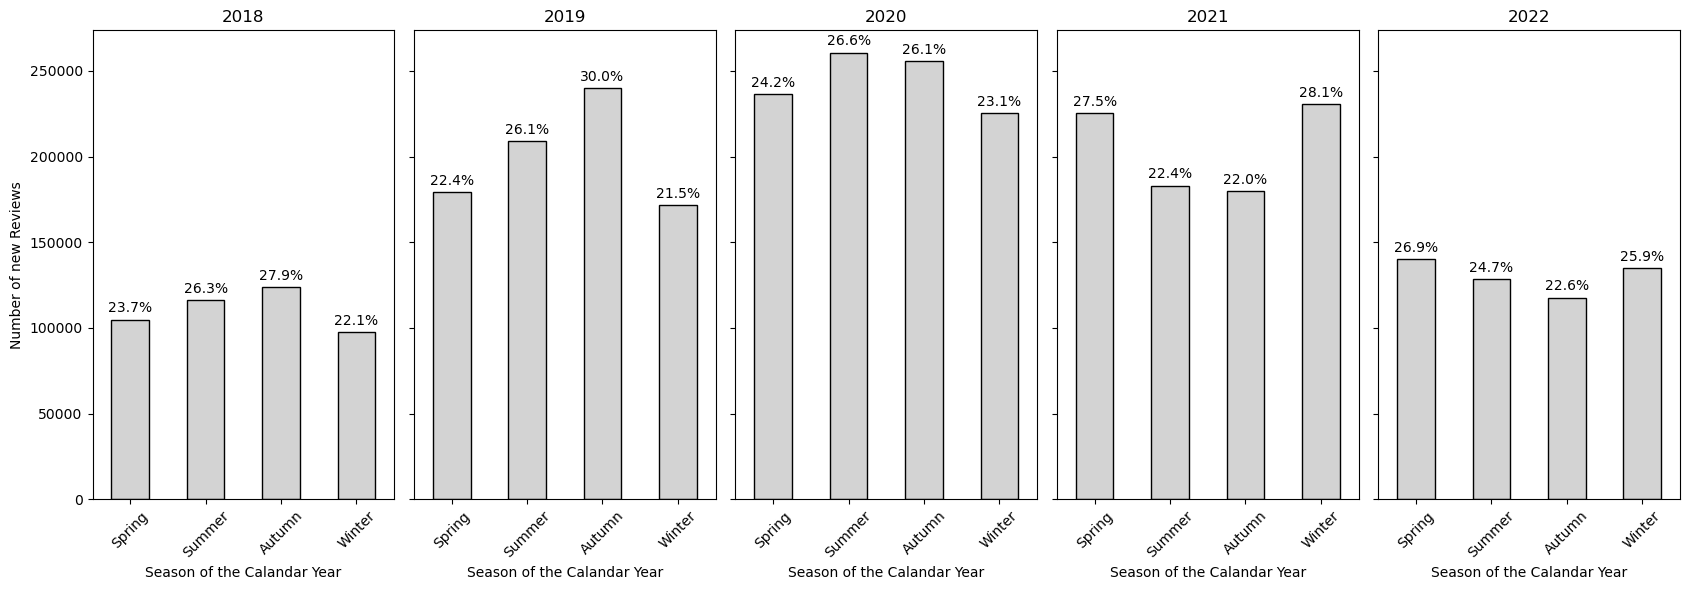

In [108]:
plot_barplot_distribution_by_year(
    data_frame=transposed_df_month_counts.iloc[:, -7:-1],
    x_label='Season of the Calandar Year',
    y_label='Number of new Reviews'
)

#### Statistical Inference

From the analysis above, based on the total cumulative number of reviews written during the entire dataset accumulation period, greater activity can be noticed at the end of winter and beginning of autumn. After the 2020, in 2021 a temporary change can be seen regarding the number of new reviews (it may be impacted by Covid pandemic restrictions). Nevertheless, it can be seen that in recent years, it is approaching the proportion of the pre-pandemic period, when summer and autumn have higher listener withdrawals when finding reviews, writing activity than other times of the year.

In the next step, we will perform a two-sample t-test using hypothesis testing to determine whether there is a statistically significant difference in the mean number of reviews written per day between the summer and autumn months and the rest of the months since the year 2022.

__Null Hypothesis__ (H0): The average number of reviews written per day during the summer and autumn since 2022 is equal to the average number of reviews written per day during the remaining period since year 2022:

$\mu_1= \mu_2$

__Alternative Hypothesis__ (Ha): The average number of reviews written per day during the summer and autumn since 2022 is not equal to the average number of reviews written per day during the remaining period since year 2022:

$\mu_1 \neq \mu_2$

The observations within each sample are assumed as independent of each other.

The sample sizes of each type of weekday is assumed to be sufficiently large (n ≥ 30).

Significance Level (α) is chosen to be equal to 0.05.

For further analysis, two data sets are prepared, which contain data on the number of reviews per hour, by period of time in a day.

In [109]:
reviews_between_6_and_11 = (
    df_timestamp[df_timestamp['year'] >= 2022]
    .loc[df_timestamp['month'].between(6, 11)]
    .groupby(['date', 'day'])
    .size()
    .reset_index(name='count')
)

reviews_except_between_6_and_11 = (
    df_timestamp[df_timestamp['year'] >= 2022]
    .loc[df_timestamp['month'].between(0, 5) | df_timestamp['month'].between(12, 12)]
    .groupby(['date', 'day'])
    .size()
    .reset_index(name='count')
)

In [110]:
perform_two_sample_t_test(
    sample_data_1 = reviews_between_6_and_11['count'],
    sample_data_2 = reviews_except_between_6_and_11['count'],
    alpha = 0.05
)

Calculated t-statistic value = -1.460558241663986, corresponding p-value = 0.14490257588136224.
Fail to reject the null hypothesis. There is no significant difference between the means of two sample data.


__Conclution__: With a p-value greater than the 0.05 significance level, we fail to reject the null hypothesis. There is insufficient evidence to support a significant difference between average number of reviews written per day during the summer and autumn since and the average number of reviews written per day during the remaining period since year 2022.

In [111]:
reviews_between_6_and_11_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=reviews_between_6_and_11['count'].mean(),
    sample_std=reviews_between_6_and_11['count'].std(),
    sample_size=len(reviews_between_6_and_11['count'])
)

reviews_except_between_6_and_11_ci = calculate_confidence_interval(
    confidence=0.95,
    sample_mean=reviews_except_between_6_and_11['count'].mean(),
    sample_std=reviews_except_between_6_and_11['count'].std(),
    sample_size=len(reviews_except_between_6_and_11['count'])
)

In [112]:
print(f'Based on a data  collected since the 2022, with 95% confidence, '
      f'the average number of reviews written per day during the summer and autumn '
      f'is estimated to fall within the range of {int(reviews_between_6_and_11_ci[0])} to {int(reviews_between_6_and_11_ci[1])}, '
      f'while for the remaining days of the year, it is estimated to fall within the range of {int(reviews_except_between_6_and_11_ci[0])} '
      f'to {int(reviews_except_between_6_and_11_ci[1])}. '
      f'This suggests that we are 95% confident that the true average number of new reviews per day '
      f'for the mentioned time periods falls within these intervals.')

Based on a data  collected since the 2022, with 95% confidence, the average number of reviews written per day during the summer and autumn is estimated to fall within the range of 1304 to 1387, while for the remaining days of the year, it is estimated to fall within the range of 1343 to 1460. This suggests that we are 95% confident that the true average number of new reviews per day for the mentioned time periods falls within these intervals.


# Interpretation and Conclusion

## Analysis overview

The insights obtained after analyzing the dataset are presented below:

* Based on the analysis above, a noticeable trend emerges: as the number of reviews or podcasts increases, the overall rating score of the category tends to improve, and vice versa. This suggests that to have a popular and highly-rated podcast, it is essential to focus on both factors - quality and popularity.
* The results of hypothesis testing reveal that the following top three general categories have statistically significantly larger mean values than the dataset's average:
    1. Business
    2. Education
    3. Religion
* Hypothesis testing also provides sufficient evidence for the following findings:
    1. There is a significant difference between the average number of reviews written on workdays and weekends, based on data collected since 2019.
    2. There is a significant difference between the average number of reviews written per hour during the period from 08:00 to 16:00 and during the remaining hours of the day, based on data collected since 2019.
* However, hypothesis testing did not yield sufficient evidence to support the following conclusions:
    1. A significant difference in the average number of reviews written per day between the period of days in a month between 21 and 31 and the remaining days of the month, based on data collected since 2019.
    2. A significant difference in the average number of reviews written per day during the summer and autumn and during the remaining periods since 2022.

## Conclution

Based on the insights obtained from the analysis of podcast data and user behavior, the following recommendations are proposed for podcast publishers and sponsors:
* __Selection of Podcast Category:__ to maximize the chances of success, it is advisable to consider podcast categories with the highest average ratings. Based on the dataset, the top three categories in terms of rating value are business, education, and religion. These categories consistently outperform the overall podcast ratings, making them attractive choices for content creators.
* __Timing of Podcast Releases:__ the analysis has unveiled a moderately positive relationship between the mean rating value of podcasts for each category and the number of reviews, suggesting that as the number of reviews increases, the podcast's and the category to which it belongs rating tends to improve. For optimal results, it is recommended to launch new episodes on workdays, particularly during the time window from 08:00 to 16:00. This period exhibits the highest user activity, presenting a valuable opportunity to reach a larger audience.


# Google Data Studio Dashboard

A Google Data Studio dashboard can be found using the following [link](https://lookerstudio.google.com/reporting/46289989-de1a-44c2-a556-04aa15601b55).

Data preparation for use in the report:

In [113]:
df_reviews_ts = df_timestamp.groupby('year')['date'].count().reset_index()
df_reviews_ts.columns = ['Date', 'Number_of_reviews']
df_reviews_ts['Date'] = pd.to_datetime(df_reviews_ts['Date'], format='%Y', errors='coerce')

In [114]:
df_weekday_reviews = pd.DataFrame(
    {
        'Weekday': ['Workday', 'Weekend'],
        'Total_number_of_Reviews': [workday_reviews['count'].sum(), weekend_reviews['count'].sum()],
        'Reviews_per_day_ci_lower_bound': [int(workday_reviews_ci[0]), int(weekend_reviews_ci[0])],
        'Reviews_per_day_ci_upper_bound': [int(workday_reviews_ci[1]), int(weekend_reviews_ci[1])]
    }
)

In [115]:
df_hourly_reviews = pd.DataFrame(
    {
        'Time_period': ['Reviews_between_08_and_16', 'Reviews_between_16_and_08'],
        'Total number of Reviews': [reviews_between_8_and_16['count'].sum(), reviews_except_between_8_and_16['count'].sum()],
        'Reviews per day ci lower bound': [int(reviews_between_8_and_16_ci[0]), int(reviews_except_between_8_and_16_ci[0])],
        'Reviews per day ci upper bound': [int(reviews_between_8_and_16_ci[1]), int(reviews_except_between_8_and_16_ci[1])]
    }
)

In [116]:
df_categories_overview.to_csv('df_categories_overview.csv', index=False)
df_reviews_ts.to_csv('df_reviews_ts.csv', index=False)
df_weekday_reviews.to_csv('df_weekday_reviews.csv', index=False)
df_hourly_reviews.to_csv('df_hourly_reviews.csv', index=False)